In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from PIL import Image
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 5#TODO: enter the number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal\calibration*.jpg')


In [2]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(undist, nx, ny):
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

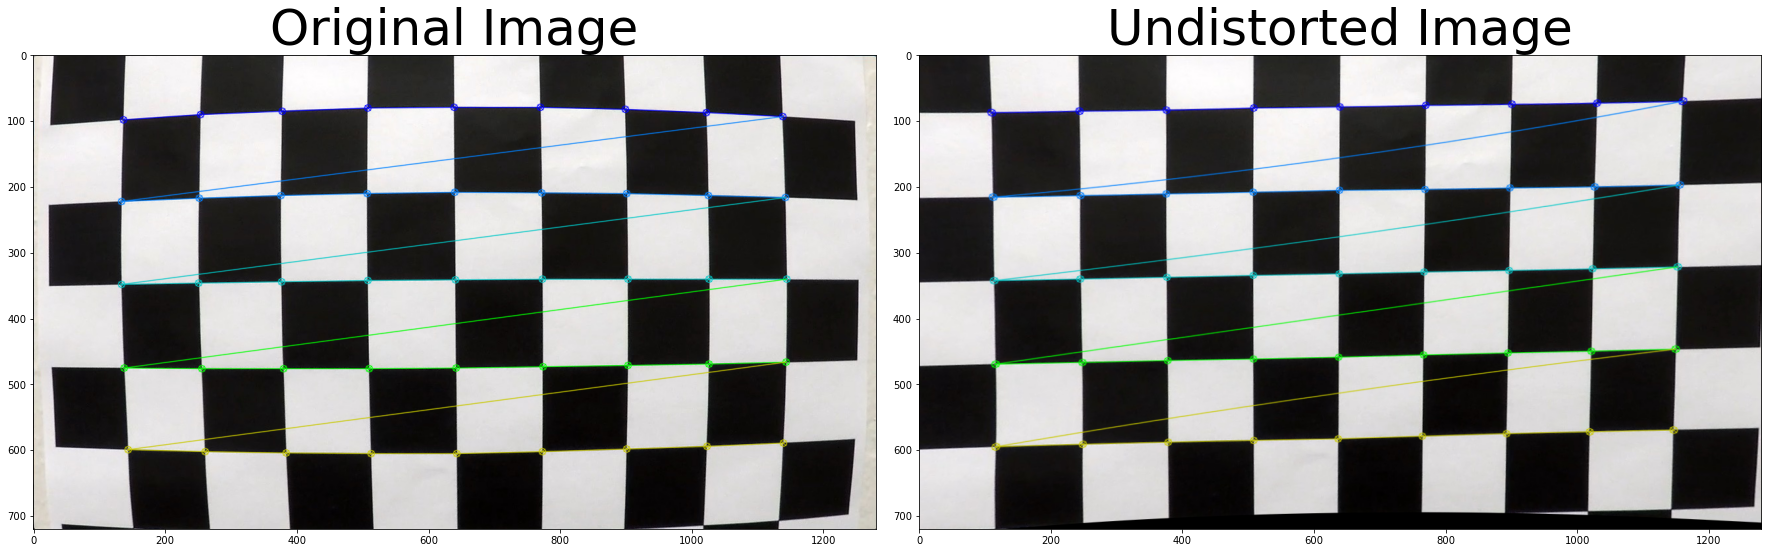

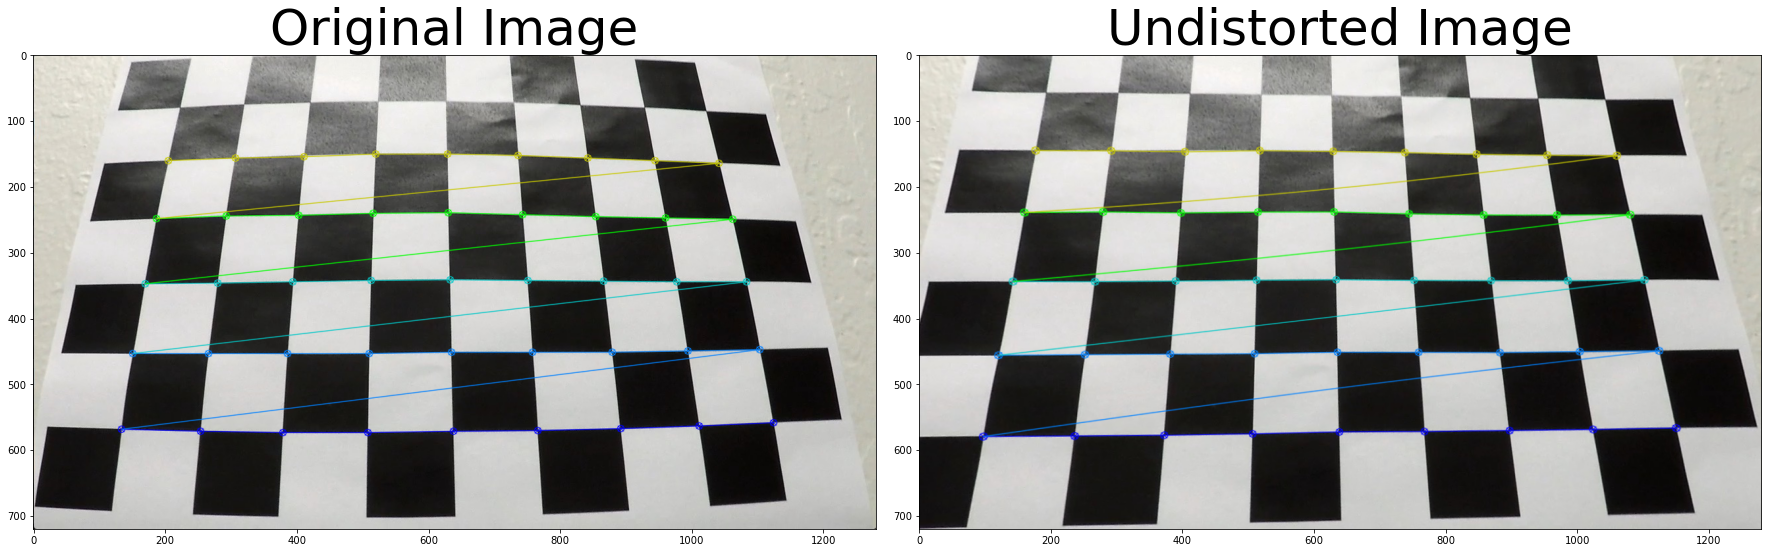

In [3]:
# Arrays to store object and image points from all the image
objpoints = [] # 3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points ,like (0,0,0),(1,0,0)......,(10,4,....)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)# x,y coordinates

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    
    #undistorted = cal_undistort(img, objpoints, imgpoints)
    #Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #find the chessboard corners
    
    ret , corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    #if coners are found ,add object points,imag points
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #draw and display the corners
        img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        im = Image.fromarray(img)
        filename = 'output_images/'+ fname
        newstr = filename.replace("camera_cal\\", "")
        im.save(newstr)
        im = Image.fromarray(undistorted)
        filename = 'output_images/_undistorted_'+ fname
        newstr = filename.replace("camera_cal\\", "")
        im.save(newstr)




In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

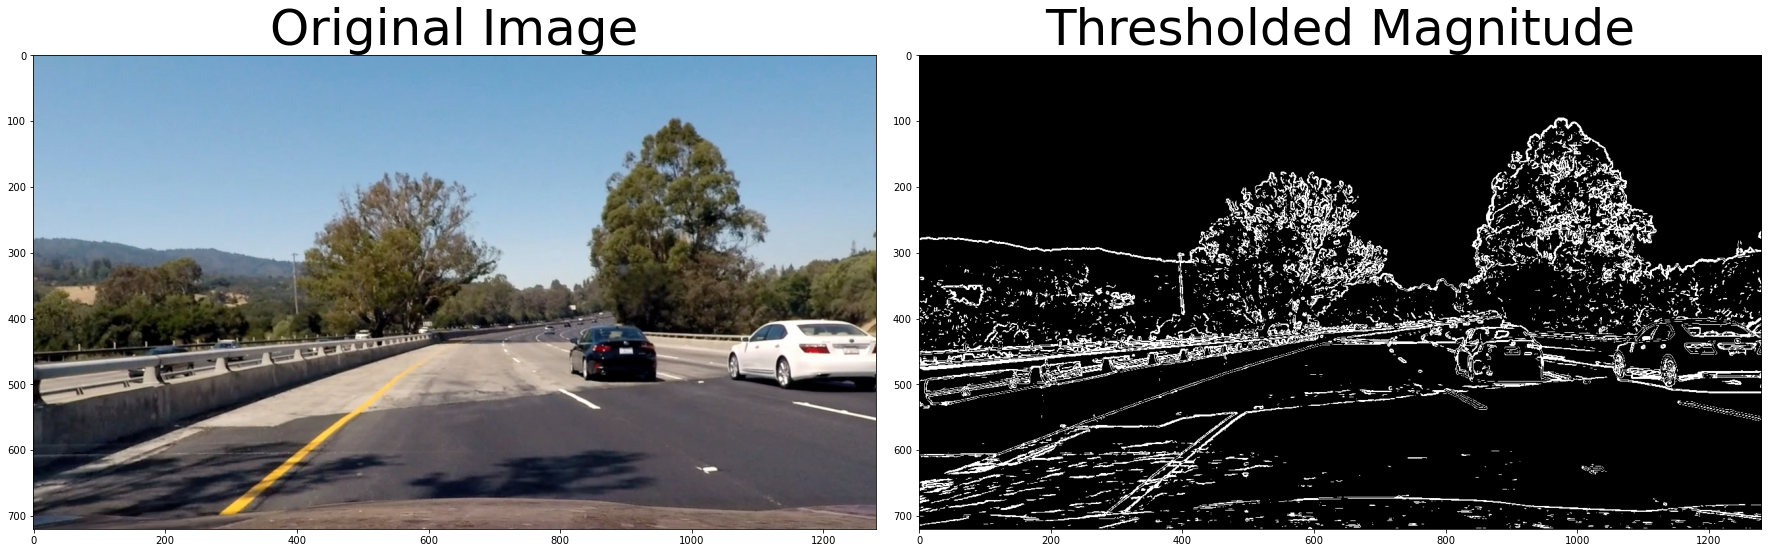

In [5]:
# Read in an image
image = mpimg.imread('test_images\\test4.jpg')
image = cal_undistort(image, objpoints, imgpoints)
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0 ,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1 ,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

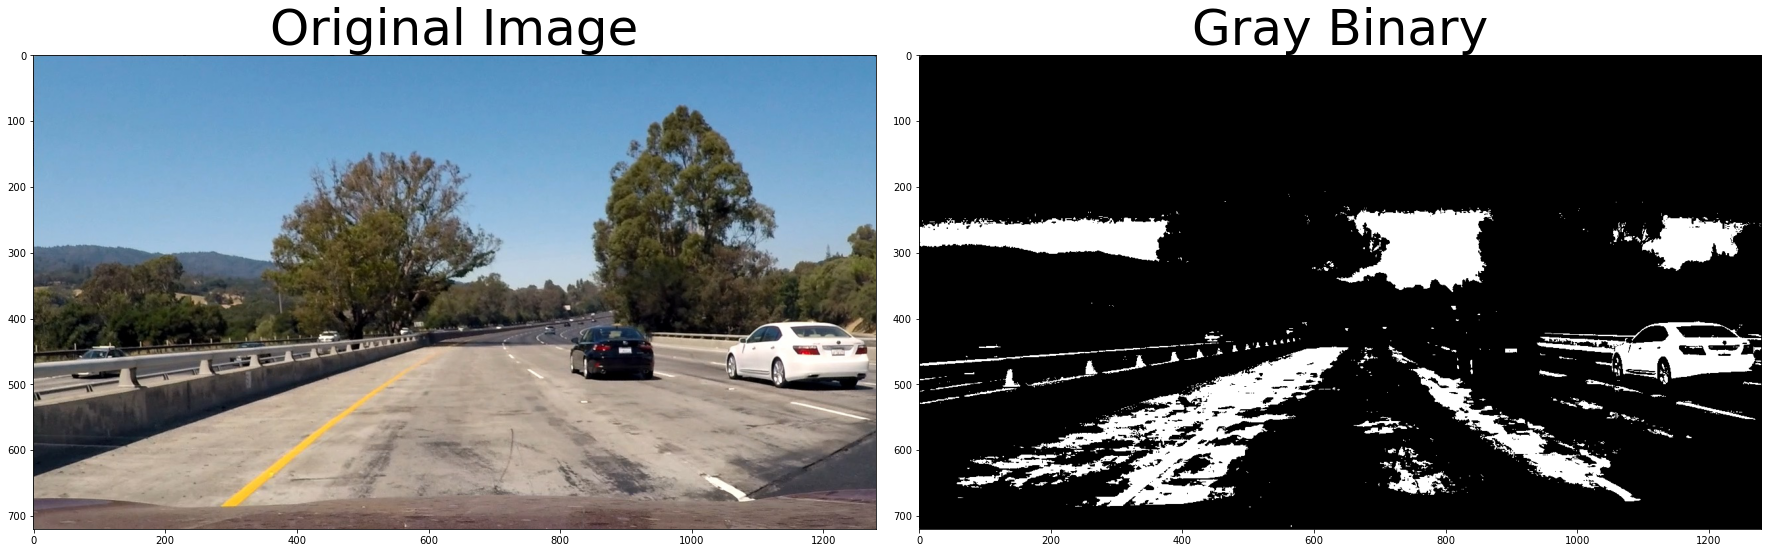

In [7]:
image = mpimg.imread('test_images\\test1.jpg')
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Gray Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

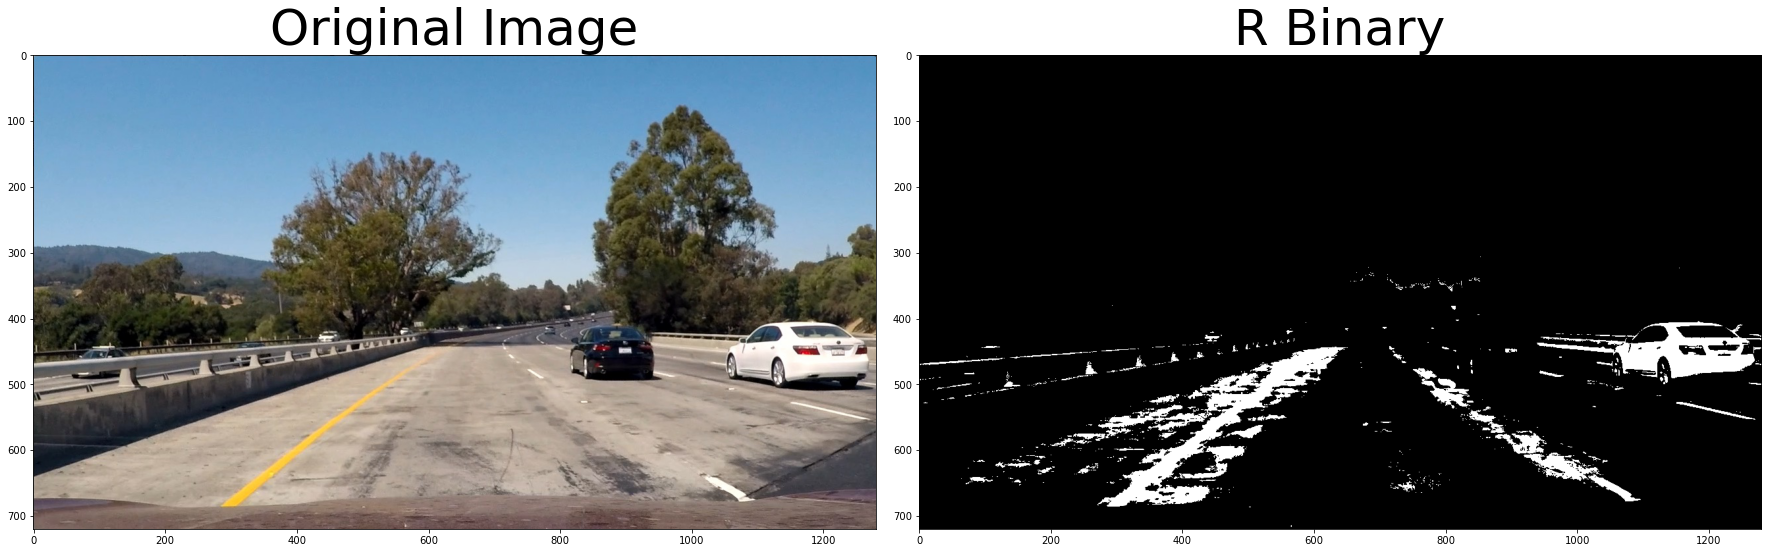

In [8]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('R Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

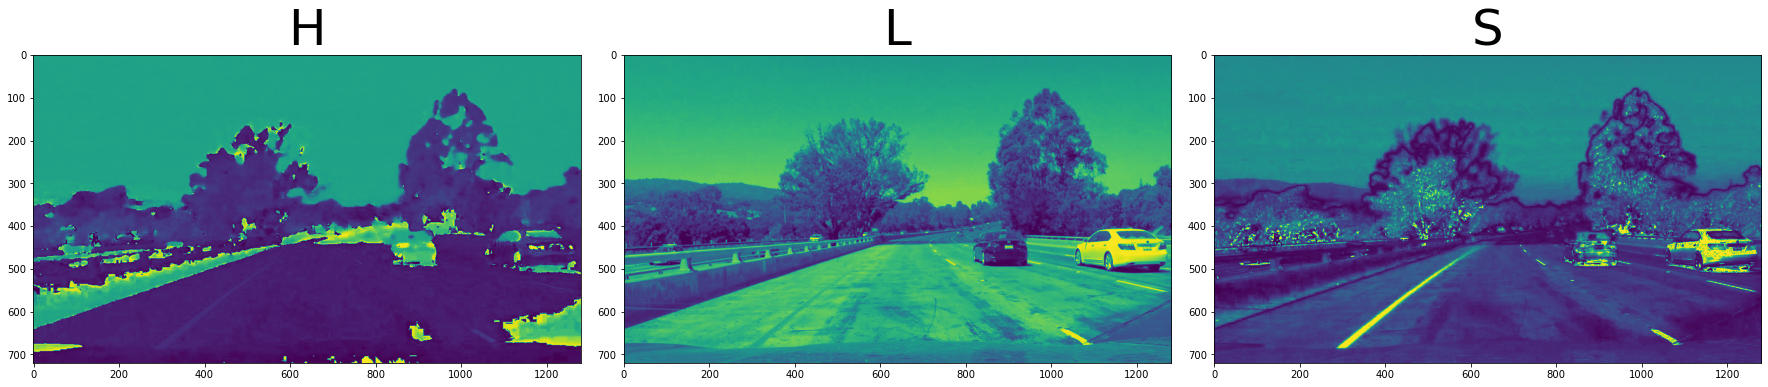

In [9]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('H', fontsize=50)
ax2.imshow(L)
ax2.set_title('L', fontsize=50)
ax3.imshow(S)
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

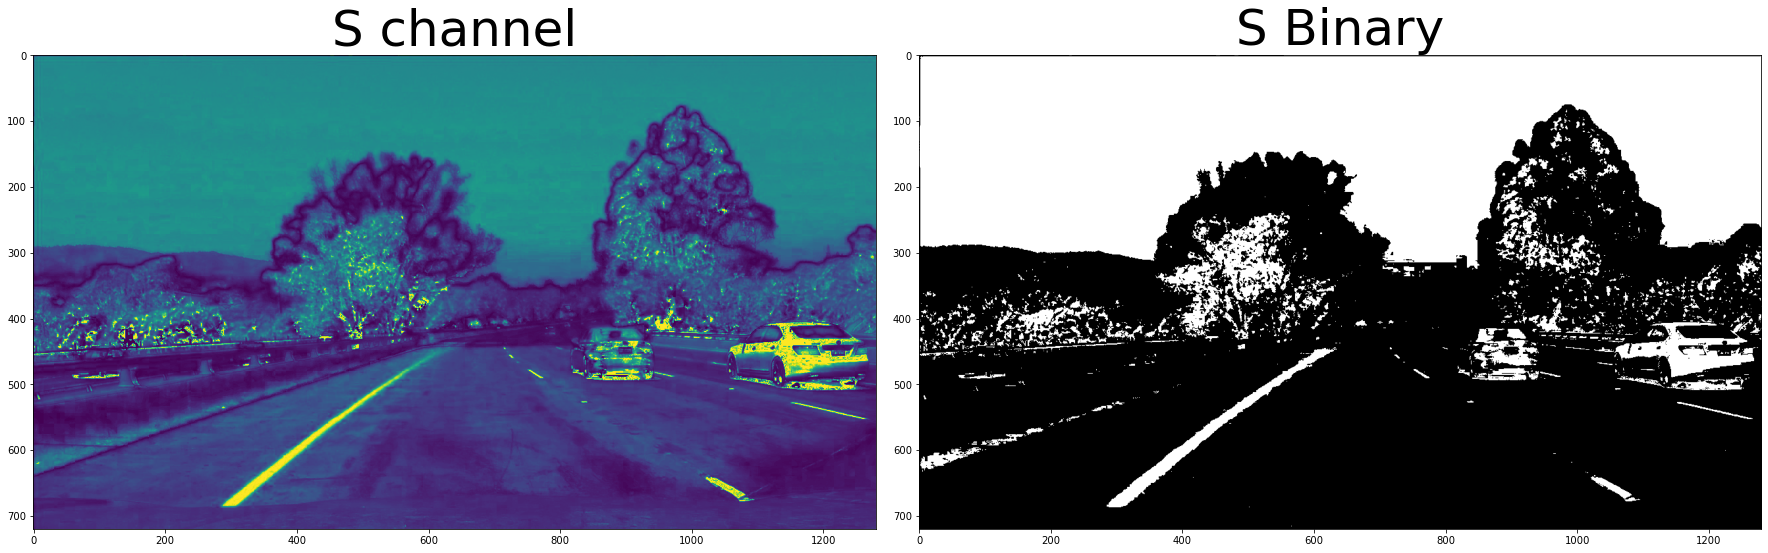

In [10]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S)
ax1.set_title('S channel', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('S Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

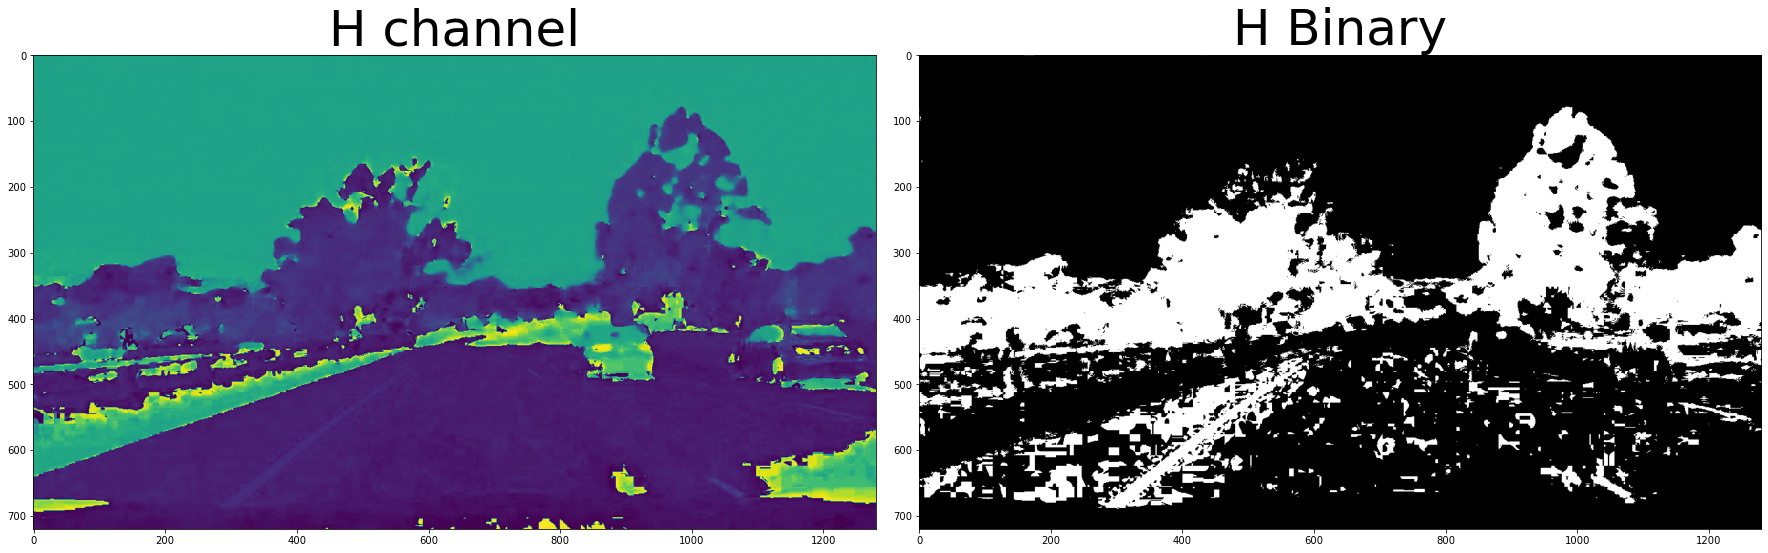

In [11]:
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('H channel', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('H Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

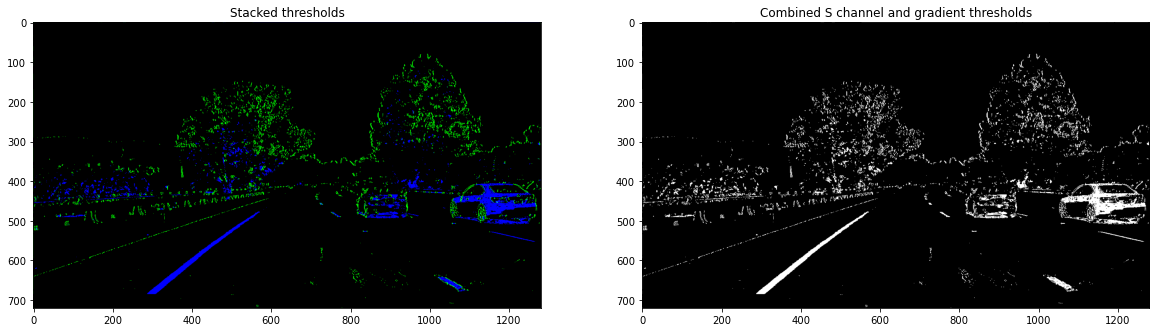

In [12]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 40
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [13]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    List = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if (slope >0.5  and slope<0.8)  or (slope <-0.6 and slope >-0.8):
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                List.append([x1,y1])
                List.append([x2,y2])
    corner = find_four_corner(List)
    return corner
def find_four_corner(List):
    corner = []
    corner.append(List[0])
    corner.append(List[1])
    corner.append(List[2])
    corner.append(List[3])
    for value in List:
        #print("\nx=",value[0],"y=",value[1])
        if(corner[0][0]>value[0]):
            corner[0][0] = value[0]
            corner[0][1] = value[1]
        if(corner[1][0]<value[0]):
            corner[1][0] = value[0]
            corner[1][1] = value[1]
    mean = (corner[0][0]+corner[1][0])/2;
    for value in List:
        if(corner[2][1]>value[1] and value[0]>mean):
            corner[2][0] = value[0]
            corner[2][1] = value[1]
        if(corner[3][1]>value[1] and value[0]<mean ):
            corner[3][0] = value[0]
            corner[3][1] = value[1] 
    for value in corner:
        print("\ncorner x=",value[0],"y=",value[1])
    return corner
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    corner = draw_lines(line_img, lines)
    return line_img ,corner

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


corner x= 289 y= 684

corner x= 1097 y= 675

corner x= 751 y= 478

corner x= 567 y= 477
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
[[289, 684], [1097, 675], [751, 478], [567, 477]]


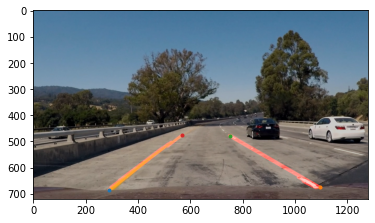

In [14]:
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(550, 430), (590, 400), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(combined_binary,vertices)

rho = 1
theta = np.pi/180
threshold = 30
min_line_len = 20 
max_line_gap = 200
line_img,corner = hough_lines(masked_edges,rho,theta,threshold,min_line_len,max_line_gap)

lines_edges = cv2.addWeighted(image, 0.8, line_img, 1, 0) 

plt.imshow(lines_edges)
for value in corner:
    plt.plot(value[0] ,value[1],'.')
print('This image is:', type(line_img), 'with dimensions:', line_img.shape)
print(corner)

#print(line_img)

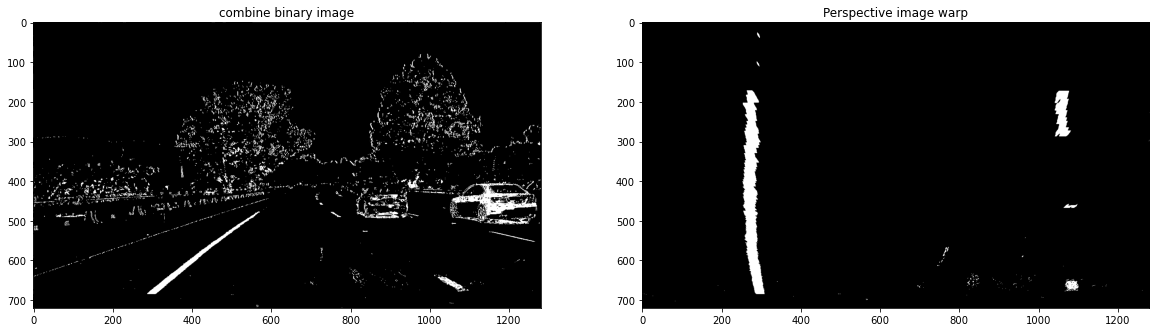

In [15]:
offset = 300
img_size = (line_img.shape[1],line_img.shape[0])
src = np.float32(
    [corner[0],corner[1],corner[2],corner[3]])
dst = np.float32(
    [corner[0],corner[1],[corner[2][0]+offset,corner[2][1]-offset],[corner[3][0]-offset,corner[3][1]-offset]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('combine binary image')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Perspective image warp')
ax2.imshow(warped, cmap='gray')

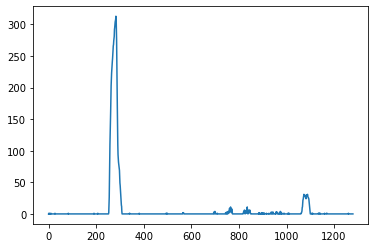

In [16]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(warped)
plt.plot(histogram)

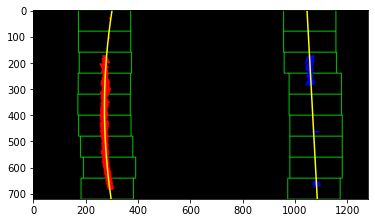

In [17]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return out_img


out_img = fit_polynomial(warped)

plt.imshow(out_img)

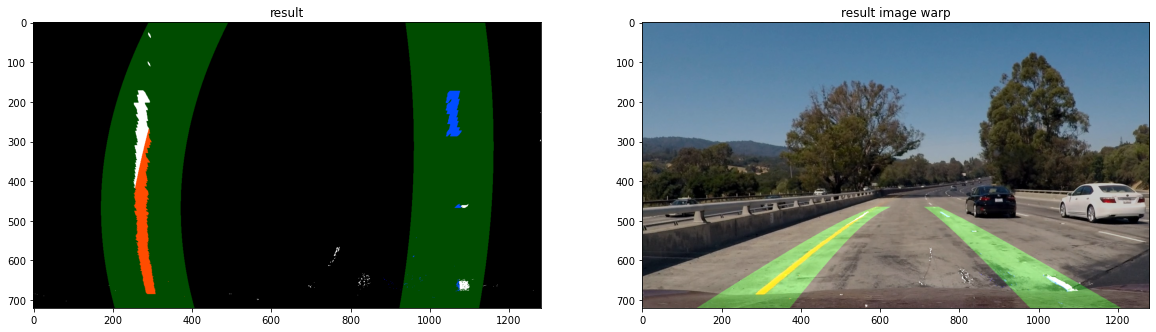

In [18]:
# Load our image - this should be a new frame since last time!


# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)
combine_inv = cv2.warpPerspective(result, Minv, img_size, flags=cv2.INTER_LINEAR)
result_inv = cv2.addWeighted(image, 0.8, combine_inv, 1, 0) 
# View your output



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('result')
ax1.imshow(result)

ax2.set_title('result image warp')
ax2.imshow(result_inv)

In [19]:
def search_around_poly_video(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Combine the result with the original image
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


In [20]:
def find_combine_binary(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 40
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [21]:
def Perspective_image(combined_binary,corner):
    
    img_size = (line_img.shape[1],line_img.shape[0])
    src = np.float32(
        [corner[0],corner[1],corner[2],corner[3]])
    dst = np.float32(
        [corner[0],corner[1],[corner[2][0]+300,corner[2][1]-200],[corner[3][0]-300,corner[3][1]-200]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

In [22]:
# TODO: Build your pipeline that will draw lane lines on the test_images
def process_image(image):
    combined_binary = find_combine_binary(image)
    warped,Minv = Perspective_image(combined_binary,corner)   
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    result = search_around_poly(warped)
    img_size = (image.shape[1],image.shape[0])
    combine_inv = cv2.warpPerspective(result, Minv, img_size, flags=cv2.INTER_LINEAR)
    result_inv = cv2.addWeighted(image, 0.8, combine_inv, 1, 0) 
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result_inv

In [65]:
import numpy as np


def measure_curvature_real(ploty,leftx,rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad




def fit_polynomial_video(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    left_curverad, right_curverad=measure_curvature_real(ploty,left_fitx,right_fitx)
    print(left_curverad, 'm', right_curverad, 'm')
   
    return color_warp, left_curverad, right_curverad

In [87]:
# TODO: Build your pipeline that will draw lane lines on the test_images
def process_image_video(image):
    combined_binary = find_combine_binary(image)
    warped,Minv = Perspective_image(combined_binary,corner)   
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    result , left_curverad, right_curverad= fit_polynomial_video(warped)
    img_size = (image.shape[1],image.shape[0])
    combine_inv = cv2.warpPerspective(result, Minv, img_size)
    result_inv = cv2.addWeighted(image,1, combine_inv, 0.3, 0) 
    text1 = 'Left curve '+str(left_curverad)+'m'
    text2 = 'Right curve '+str(right_curverad)+'m'
    text3 = 'middle curve '+str((right_curverad+left_curverad)/2)+'m'
    cv2.putText(result_inv, text1, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(result_inv, text2, (10, 80), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(result_inv, text3, (10, 120), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 1, cv2.LINE_AA)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result_inv

In [88]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
project_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

467.80880879435614 m 356.46009067540973 m
Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4

467.80880879435614 m 356.46009067540973 m


t:   0%|▎                                                                   | 6/1260 [00:00<02:09,  9.71it/s, now=None]

430.9383329270182 m 449.4513541000165 m
417.44650456717545 m 568.3709053700219 m
403.9259266270726 m 601.4389500810429 m
425.89265361356155 m 718.7300709356714 m
450.69590828280263 m 768.1274576893906 m


t:   1%|▌                                                                  | 10/1260 [00:00<01:40, 12.43it/s, now=None]

468.05210304886737 m 726.4049936493955 m
462.74795728290894 m 1194.442580709004 m
489.27293193812034 m 1360.8915432861506 m
504.81841676066983 m 2965.6708888677076 m


t:   1%|▋                                                                  | 14/1260 [00:00<01:24, 14.73it/s, now=None]

537.064010824984 m 2014.0532928505763 m
569.4566861306158 m 5631.134633650468 m
615.3072016314985 m 911.0407820414382 m
635.8140779831103 m 540.3176665909123 m
600.415074941196 m 833.0039371957171 m


t:   1%|▉                                                                  | 18/1260 [00:01<01:14, 16.68it/s, now=None]

585.0062926903356 m 799.2894439845795 m
589.5046515474788 m 758.1412075160027 m
602.7616284955783 m 920.5640377835176 m


t:   2%|█▏                                                                 | 22/1260 [00:01<01:11, 17.33it/s, now=None]

606.3153535013962 m 680.6114459455704 m
735.4872875121408 m 642.8245046853458 m
793.2623076095751 m 600.064000633191 m
752.9811967080628 m 762.3511099751457 m


t:   2%|█▍                                                                 | 26/1260 [00:01<01:08, 18.07it/s, now=None]

791.9401372026011 m 691.8409021894997 m
760.1186154695872 m 696.0327163661758 m
680.6832520638466 m 735.2291788453297 m
650.948133680503 m 518.6311955294041 m
626.7021248299742 m 384.2693871243939 m


t:   3%|█▋                                                                 | 32/1260 [00:01<01:07, 18.22it/s, now=None]

608.8680674463753 m 430.20956869633306 m
577.9633398921212 m 665.2752559393799 m
494.16961434705314 m 583.7217909974825 m
473.3049088974635 m 690.8013545036652 m


t:   3%|█▉                                                                 | 36/1260 [00:02<01:08, 17.91it/s, now=None]

426.08927291830565 m 668.4432265222391 m
448.5188131538867 m 849.4653908717219 m
429.35260621185637 m 591.0220555919327 m
398.05879429558104 m 580.7084377174009 m


t:   3%|██                                                                 | 38/1260 [00:02<01:11, 17.18it/s, now=None]

384.6038185800027 m 645.7722380578172 m
389.5661908504852 m 406.60489204683347 m
369.21666208417474 m 433.69396886964483 m
347.26926678654326 m 504.2877442263746 m


t:   3%|██▏                                                                | 42/1260 [00:02<01:13, 16.59it/s, now=None]

353.75472556221126 m 467.24212164437074 m
351.5267599350117 m 434.8117868811635 m
347.69854487582 m 485.16207195194625 m
357.584593761599 m 512.0300711573622 m


t:   4%|██▌                                                                | 48/1260 [00:02<01:13, 16.54it/s, now=None]

377.22680835716346 m 555.5291582704589 m
406.44276430528333 m 705.6323525535317 m
419.4129346343955 m 735.4876085042687 m
425.2458926611487 m 597.3578410115189 m


t:   4%|██▊                                                                | 52/1260 [00:03<01:11, 17.01it/s, now=None]

432.1271162383208 m 480.58518305209134 m
469.8609866477355 m 499.7083865570004 m
500.29486156411184 m 576.6638677608754 m
551.4885870102927 m 357.12105303490364 m


t:   4%|██▉                                                                | 56/1260 [00:03<01:09, 17.27it/s, now=None]

581.7833760441345 m 479.74520685348745 m
578.7362264369281 m 645.8569041360338 m
627.27318943425 m 542.5751725327362 m
670.7487684880548 m 560.0109361626372 m


t:   5%|███                                                                | 58/1260 [00:03<01:11, 16.71it/s, now=None]

707.7536576495876 m 634.7165001934688 m
698.7708714121264 m 1476.5612335677456 m
724.1774212293487 m 1026.5377624309276 m
659.6032892528127 m 761.5866361333443 m


t:   5%|███▍                                                               | 64/1260 [00:03<01:09, 17.10it/s, now=None]

661.1269939788934 m 1003.413025850048 m
582.2918150760278 m 476.7034119055975 m
570.5339072497271 m 626.3222066467808 m
564.4455642778499 m 837.2452045448618 m


t:   5%|███▌                                                               | 66/1260 [00:03<01:10, 16.87it/s, now=None]

545.4747000009831 m 840.5325388054583 m
532.1396909161555 m 798.0912128116357 m
516.5205194747405 m 792.3656460909433 m
526.0459530051547

t:   6%|███▋                                                               | 70/1260 [00:04<01:10, 16.90it/s, now=None]

 m 935.4809516233234 m
552.0091099911223 m 933.1176654725203 m
555.1476515389189 m 558.4666344098764 m
579.1023700141658 m 615.3125957220699 m


t:   6%|███▉                                                               | 74/1260 [00:04<01:10, 16.85it/s, now=None]

603.844552466064 m 527.6866816868841 m
648.8322976679174 m 994.2163348008678 m
681.1683022264493 m 1188.0632689573772 m
735.3435346573306 m 350.598079208235 m


t:   6%|████▏                                                              | 78/1260 [00:04<01:12, 16.27it/s, now=None]

792.7214946123387 m 391.0226226776777 m
919.296238340295 m 430.9150400203042 m
998.9740026774889 m 421.3262269763879 m
1106.5609678777998

t:   6%|████▎                                                              | 80/1260 [00:04<01:13, 16.02it/s, now=None]

 m 513.197058350915 m
1118.0646662678892 m 595.5720634500263 m
1058.033650048628 m 552.4668645102876 m


t:   7%|████▍                                                              | 84/1260 [00:05<01:14, 15.69it/s, now=None]

1101.519064360236 m 577.5886346780645 m
1020.7056936302919 m 601.7459328064189 m
935.2081004773487 m 794.0805232687144 m
1008.7296443718341 m 1901.2578433868318 m


t:   7%|████▋                                                              | 88/1260 [00:05<01:12, 16.19it/s, now=None]

906.4662248028739 m 1013.835953630016 m
828.5576757005063 m 1165.8875904005051 m
663.1126791284044 m 1078.9852708219682 m
568.0386336890755 m 459.4095502846896 m


t:   7%|████▉                                                              | 92/1260 [00:05<01:14, 15.59it/s, now=None]

526.4622100973334 m 567.0482617107654 m
484.8327859546981 m 596.3343203783139 m
481.2973922865165 m 627.6943758262314 m
496.7214142882229 m 616.02015468983 m


t:   8%|█████                                                              | 96/1260 [00:05<01:11, 16.19it/s, now=None]

469.1028093919498 m 703.2895603054942 m
462.49950380557203 m 521.7701966417595 m
472.1072699003847 m 576.2475553900548 m
480.8030284779036 m 452.9957055810722 m


t:   8%|█████▏                                                            | 100/1260 [00:06<01:12, 16.03it/s, now=None]

487.296052466505 m 621.0754392178534 m
502.7553451765285 m 500.761127033693 m
506.39328807192396 m 525.9247925222263 m
502.16976973486084

t:   8%|█████▎                                                            | 102/1260 [00:06<01:14, 15.62it/s, now=None]

 m 388.92436626828714 m
500.9465097901402 m 419.92356073618106 m
494.2905191021975 m 449.509761734456 m


t:   8%|█████▌                                                            | 106/1260 [00:06<01:18, 14.76it/s, now=None]

495.7292111717016 m 529.3659583449956 m
493.2672222175177 m 498.37850522586837 m
510.8611088990338 m 545.3977130581862 m
508.90789766114045 m 579.64202300843 m


t:   9%|█████▊                                                            | 110/1260 [00:06<01:12, 15.81it/s, now=None]

537.5693831987237 m 550.6869953156806 m
493.3995346876241 m 715.8636071498838 m
486.82034763868626 m 473.4872639773449 m
482.17457333104414 m 442.333154517506 m


t:   9%|█████▉                                                            | 114/1260 [00:06<01:10, 16.26it/s, now=None]

469.7582238599434 m 484.5254444141205 m
503.66623258205755 m 500.0603399834162 m
470.9756781600954 m 449.21069993547627 m
470.67606806267924 m 358.22515629799193 m


t:   9%|██████▏                                                           | 118/1260 [00:07<01:08, 16.61it/s, now=None]

446.8612679172986 m 430.0308679784849 m
428.9945371616305 m 389.85892518662996 m
421.3595604203121 m 432.7857925919472 m
413.11430123855536 m 420.8585507008118 m


t:  10%|██████▍                                                           | 122/1260 [00:07<01:10, 16.25it/s, now=None]

418.9832899690806 m 484.42164472073387 m
412.99665583940794 m 375.590802879275 m
411.7702951407407 m 409.0792571783283 m
413.39887462721526

t:  10%|██████▌                                                           | 126/1260 [00:07<01:07, 16.71it/s, now=None]

 m 389.0157769888616 m
394.9661295537852 m 374.070548640955 m
401.9335384611705 m 323.05987431218756 m
406.35587852923146 m 387.20444233807365 m


t:  10%|██████▋                                                           | 128/1260 [00:07<01:07, 16.74it/s, now=None]

433.6692778547559 m 390.8934188174493 m
427.53597230686336 m 413.99812614403834 m
438.978811573806 m 418.75674251796306 m
420.9009274046739 m 425.4207513558445 m


t:  10%|██████▉                                                           | 132/1260 [00:08<01:08, 16.46it/s, now=None]

435.86607297007623 m 459.9602593361356 m
462.76534840869107 m 505.86554599194324 m
471.728022697246 m 459.97867575710376 m
476.09669445239393 m 416.0956194229905 m


t:  11%|███████                                                           | 136/1260 [00:08<01:09, 16.23it/s, now=None]

477.1323155227638 m 409.92916185413037 m
488.46445695851634 m 482.96197781182883 m
509.0862387144392 m 437.69760103394634 m


t:  11%|███████▎                                                          | 140/1260 [00:08<01:09, 16.13it/s, now=None]

525.7724514872472 m 465.12549394170884 m
575.932730906095 m 471.34785262584427 m
554.7025796118154 m 581.80507250498 m
599.3826246630392 m 587.8988761151994 m


t:  11%|███████▌                                                          | 144/1260 [00:08<01:07, 16.50it/s, now=None]

596.8872347428631 m 803.7863809959683 m
621.4989029347918 m 667.4658214379417 m
593.2689488681207 m 551.653662813839 m
573.9864831776442 m 841.121474399687 m


t:  12%|███████▊                                                          | 148/1260 [00:09<01:06, 16.63it/s, now=None]

581.1834425984584 m 709.3450953891569 m
619.4152675644274 m 613.6443708170485 m
644.1753620892567 m 703.1195469193663 m
593.7539623992857 m 505.5780805191584 m


t:  12%|███████▉                                                          | 152/1260 [00:09<01:06, 16.59it/s, now=None]

601.6887472996026 m 358.0556559405765 m
643.0687368667393 m 394.96386268201076 m
645.0328518531858 m 436.45499325460884 m
654.0264467157331 m 435.49824079645 m


t:  12%|████████▏                                                         | 156/1260 [00:09<01:04, 17.02it/s, now=None]

596.7183370361865 m 503.9655456369493 m
646.9873887428569 m 559.8947278222997 m
616.4828072715687 m 586.1652681553799 m
599.2665790073588 m 616.9389316777194 m


t:  13%|████████▍                                                         | 160/1260 [00:09<01:04, 17.09it/s, now=None]

622.3170630099302 m 608.7048974427603 m
551.0040255128886 m 562.1235060488799 m
572.153462615651 m 758.1988640025685 m
504.5719527003218 m 991.7602875733378 m


t:  13%|████████▌                                                         | 164/1260 [00:10<01:03, 17.14it/s, now=None]

503.77464336223767 m 820.8659217496631 m
510.88389828169227 m 700.4915793282695 m
512.0363283745828 m 498.63839765030474 m
502.8855452239695 m 632.814989661685 m


t:  13%|████████▊                                                         | 168/1260 [00:10<01:02, 17.47it/s, now=None]

499.4358192732194 m 701.861247092514 m
511.0625533779004 m 570.5443807685035 m
509.55850691832114 m 568.7789686488841 m
565.711861318328 m 621.5156462334792 m


t:  14%|█████████                                                         | 172/1260 [00:10<01:02, 17.39it/s, now=None]

583.55230215198 m 842.200262688511 m
619.4939198386047 m 561.2020041306439 m
652.9032325020493 m 432.02058918610896 m
650.6798349501946 m 322.575236182902 m


t:  14%|█████████▏                                                        | 176/1260 [00:10<01:03, 17.08it/s, now=None]

625.1098246060209 m 351.1115864782128 m
566.8304271571704 m 275.0429324892621 m
538.0830217111877 m 268.18893509438976 m
508.06157540735893 m

t:  14%|█████████▎                                                        | 178/1260 [00:10<01:07, 16.11it/s, now=None]

 259.340460220941 m
537.2306898004845 m 286.881059441957 m
527.6263688429474 m 268.8820270513504 m


t:  14%|█████████▌                                                        | 182/1260 [00:11<01:17, 13.87it/s, now=None]

520.4246112298662 m 296.0693812530502 m
520.042285131969 m 296.0191989153385 m
467.4085747148018 m 325.9800990031625 m


t:  15%|█████████▋                                                        | 184/1260 [00:11<01:21, 13.17it/s, now=None]

470.2510849063014 m 331.8755739796354 m
422.3146450242844 m 301.5640287692908 m
391.6280130498086 m 346.3382243511027 m


t:  15%|█████████▊                                                        | 188/1260 [00:11<01:24, 12.63it/s, now=None]

360.2070193626861 m 447.9834543890452 m
321.78011742488445 m 342.1326401960263 m
316.5181189986217 m 391.1636911354021 m


t:  15%|█████████▉                                                        | 190/1260 [00:11<01:29, 11.97it/s, now=None]

313.5002877860549 m 294.15267922672615 m
318.6321775360304 m 356.9399887196077 m
326.2806989910808

t:  15%|██████████                                                        | 192/1260 [00:12<01:29, 11.90it/s, now=None]

 m 418.2623018555358 m
321.06307252141846 m 449.07090484883184 m
343.63926455289464 m 487.62891126267755 m


t:  15%|██████████▏                                                       | 194/1260 [00:12<01:29, 11.86it/s, now=None]

350.7226360986491 m 382.6765168904838 m
361.46415793234064 m 443.6606230433616 m
364.7160592715336 m 356.0880288401553 m


t:  16%|██████████▎                                                       | 198/1260 [00:12<01:33, 11.38it/s, now=None]

428.4481616517578 m 411.59028315299986 m
486.01586704001005 m 564.5902633650326 m
529.0106886952723

t:  16%|██████████▍                                                       | 200/1260 [00:12<01:34, 11.16it/s, now=None]

 m 462.5641427544078 m
589.0573277047565 m 656.8349971373727 m
593.6406348900363 m 550.8279317852061 m


t:  16%|██████████▌                                                       | 202/1260 [00:12<01:34, 11.21it/s, now=None]

615.5245056051533 m 714.5467934105243 m
549.7653240937627 m 411.2309618723347 m


t:  16%|██████████▋                                                       | 204/1260 [00:13<01:42, 10.29it/s, now=None]

514.5845492469651 m 532.5412245519046 m
523.7882252120316 m 621.66369694909 m


t:  16%|██████████▊                                                       | 206/1260 [00:13<01:43, 10.15it/s, now=None]

503.97883196613554 m 491.8082465496732 m
483.85887726664924 m 457.7339276676585 m
439.89442153219886 m 359.62320693257806 m


t:  17%|███████████                                                       | 210/1260 [00:13<01:40, 10.46it/s, now=None]

427.41508002571896 m 369.9798933869957 m
427.2755407742933 m 422.3829452447257 m


t:  17%|███████████                                                       | 212/1260 [00:13<01:40, 10.48it/s, now=None]

435.63678332420636 m 463.6384404335757 m
454.67846266549617 m 474.4824082085058 m
444.1671630955134 m 449.26002831737037 m


t:  17%|███████████▏                                                      | 214/1260 [00:14<01:36, 10.89it/s, now=None]

440.56075930903836 m 460.7785748088036 m
416.4782143725264 m 443.4589360310759 m
408.8586280836082 m 709.3561256784523 m


t:  17%|███████████▍                                                      | 218/1260 [00:14<01:34, 10.98it/s, now=None]

410.41571819011506 m 598.1074139268754 m
421.47742919102234 m 647.0319622989648 m
444.105579412778

t:  17%|███████████▌                                                      | 220/1260 [00:14<01:33, 11.11it/s, now=None]

 m 691.4997845789862 m
437.45074774409534 m 686.8271819147326 m
463.0036125536626 m 1211.1897524543137 m


t:  18%|███████████▋                                                      | 224/1260 [00:14<01:29, 11.57it/s, now=None]

477.07432772060906 m 1025.0364136522517 m
509.63813620674387 m 1243.1490076346226 m
529.7503750580631 m 873.7633295249351 m


t:  18%|███████████▊                                                      | 226/1260 [00:15<01:30, 11.47it/s, now=None]

507.8675140617642 m 433.14495230213015 m
533.3416725459675 m 497.2887975302538 m
517.4152295633523

t:  18%|███████████▉                                                      | 228/1260 [00:15<01:30, 11.40it/s, now=None]

 m 685.8007972745635 m
551.4483638956597 m 659.8561167306092 m
565.1631108887333 m 596.4009316555569 m


t:  18%|████████████▏                                                     | 232/1260 [00:15<01:29, 11.48it/s, now=None]

608.9015152091546 m 685.125333796168 m
650.9363535443104 m 658.8176828946448 m
634.0512685038321 m 626.1291775933976 m


t:  19%|████████████▎                                                     | 234/1260 [00:15<01:29, 11.49it/s, now=None]

671.8567952712751 m 493.5884327557214 m
676.5747713967604 m 438.1195657515581 m
667.5708037092571 m 438.8040484497951 m


t:  19%|████████████▎                                                     | 236/1260 [00:16<01:27, 11.66it/s, now=None]

666.5099555644939 m 439.08651076391095 m
625.0510114278355 m 391.4093379495749 m
618.3279190989649 m 409.89696426105877 m


t:  19%|████████████▌                                                     | 240/1260 [00:16<01:26, 11.78it/s, now=None]

555.832193179906 m 367.8415499296775 m
522.0419115352347 m 354.13161465143844 m
521.8311427221911 m 386.7324859509199 m


t:  19%|████████████▊                                                     | 244/1260 [00:16<01:26, 11.81it/s, now=None]

529.4657120305602 m 401.01193482473576 m
536.8539875835118 m 416.88708083562875 m
498.4295590168956 m 367.91461264647677 m


t:  20%|████████████▉                                                     | 246/1260 [00:16<01:26, 11.68it/s, now=None]

511.15195064657746 m 368.67281874150194 m
498.587149617014 m 390.2268068912964 m
484.2506267014391 m 383.20814537701534 m


t:  20%|█████████████                                                     | 250/1260 [00:17<01:24, 11.92it/s, now=None]

497.3252373227587 m 471.0242440323168 m
471.7446134209477 m 426.96718861637294 m
507.7735069853469 m 439.96577592026506 m


t:  20%|█████████████▏                                                    | 252/1260 [00:17<01:26, 11.61it/s, now=None]

516.1908736276278 m 397.6266537740496 m
510.395166320105 m 421.9523340655139 m
521.3393764238664 m 464.75259645662544 m


t:  20%|█████████████▍                                                    | 256/1260 [00:17<01:24, 11.87it/s, now=None]

545.4138923458333 m 490.5241875944557 m
571.4815106291558 m 552.6118455902263 m
552.2851502474182 m 470.46839289738443 m


t:  20%|█████████████▌                                                    | 258/1260 [00:17<01:24, 11.92it/s, now=None]

565.213987110845 m 433.60692704284526 m
541.9465563231417 m 478.081138202601 m
559.5877545926256 m 429.9626885766347 m


t:  21%|█████████████▋                                                    | 262/1260 [00:18<01:24, 11.82it/s, now=None]

558.2064757056041 m 305.8912889979085 m
542.126136965462 m 355.1174555588086 m
590.6839683507978 m 398.98530080529366 m


t:  21%|█████████████▊                                                    | 264/1260 [00:18<01:23, 11.95it/s, now=None]

580.5521625335383 m 425.45816487731514 m
588.4142725490511 m 416.59297088327355 m
602.6296961601748 m 452.3878669878814 m


t:  21%|██████████████                                                    | 268/1260 [00:18<01:24, 11.69it/s, now=None]

590.2824648916621 m 503.7823275221077 m
579.5765801621931 m 526.2896281786002 m
576.7653868054842 m 525.1490756279228 m


t:  21%|██████████████▏                                                   | 270/1260 [00:18<01:24, 11.69it/s, now=None]

580.1480441100051 m 471.696062002293 m
607.2001502680946 m 549.6765425937793 m
591.0325624410071

t:  22%|██████████████▏                                                   | 272/1260 [00:19<01:25, 11.59it/s, now=None]

 m 605.7202584913508 m
578.3193960510044 m 511.68607600530487 m
557.0560495056228 m 401.1505111447221 m


t:  22%|██████████████▎                                                   | 274/1260 [00:19<01:26, 11.46it/s, now=None]

580.3584501182082 m 459.37351387752113 m
567.7831094882325 m 547.2084475531507 m
581.9556518421757

t:  22%|██████████████▌                                                   | 278/1260 [00:19<01:25, 11.52it/s, now=None]

 m 611.7392421422296 m
604.5210446510522 m 623.295487744898 m
664.4042842593864 m 638.9206022981866 m


t:  22%|██████████████▋                                                   | 280/1260 [00:19<01:26, 11.36it/s, now=None]

664.2525276306184 m 676.2799533146099 m
691.92219071703 m 596.5211822567813 m
672.3151733720988 m 717.252610509659 m


t:  22%|██████████████▊                                                   | 282/1260 [00:19<01:24, 11.52it/s, now=None]

724.8965442930897 m 655.2399852893918 m
747.3220328664745 m 750.9208461570361 m
795.5848666594945 m 969.1831342856315 m


t:  23%|██████████████▉                                                   | 286/1260 [00:20<01:23, 11.60it/s, now=None]

787.2121647610094 m 476.60994892442125 m
902.3207475436438 m 595.3807238642825 m
955.3779237427764 m 642.4929486118309 m


t:  23%|███████████████                                                   | 288/1260 [00:20<01:24, 11.53it/s, now=None]

975.9243068340278 m 630.2524045251507 m
1028.5981844890566 m 773.118782443534 m
955.8706835101552 m 879.7060240721645 m


t:  23%|███████████████▎                                                  | 292/1260 [00:20<01:24, 11.43it/s, now=None]

1117.1252104525086 m 906.6309351877043 m
1032.5796771007774 m 859.7939922876224 m
1036.5910705741285 m 854.4444341470348 m


t:  23%|███████████████▍                                                  | 294/1260 [00:21<01:25, 11.29it/s, now=None]

1098.8513204700532 m 630.107617626275 m
1127.1807509696962 m 631.8743877280183 m
1111.5829133157706 m 478.1984576346515 m


t:  24%|███████████████▌                                                  | 298/1260 [00:21<01:24, 11.37it/s, now=None]

1117.7193730295444 m 529.2787493320835 m
1152.9287434567389 m 595.6174840308132 m
1200.2117156486297 m 702.6201170935318 m


t:  24%|███████████████▊                                                  | 302/1260 [00:21<01:21, 11.80it/s, now=None]

1297.3626189687097 m 849.5036415431343 m
1273.6572138060976 m 942.3877537937115 m
1259.294617459314 m 1150.888386151765 m


t:  24%|███████████████▉                                                  | 304/1260 [00:21<01:20, 11.86it/s, now=None]

1378.6302635502757 m 1450.7123027630648 m
1335.999223016388 m 1190.0855187329632 m
1576.0891480356047 m 1480.5365838535893 m


t:  24%|████████████████▏                                                 | 308/1260 [00:22<01:19, 12.03it/s, now=None]

1637.4028212424712 m 2893.058671277067 m
1660.5366811406268 m 5837.991741641187 m
1754.6103718592306 m 3509.695803840461 m


t:  25%|████████████████▏                                                 | 310/1260 [00:22<01:20, 11.82it/s, now=None]

1767.1982708850956 m 1884.7807080685182 m
1858.9107898209504 m 1887.704433875699 m
1961.0496416163257 m 4157.992815310264 m


t:  25%|████████████████▍                                                 | 314/1260 [00:22<01:18, 12.02it/s, now=None]

2153.4825862568914 m 37124.10946572621 m
3357.657133858291 m 15267.85575491992 m
4006.855769142273 m 19479.21675325311 m


t:  25%|████████████████▌                                                 | 316/1260 [00:22<01:18, 12.07it/s, now=None]

6183.781914271576 m 55936.08998053814 m
5577.489975334753 m 8019.826709807277 m
7967.387885195989 m 6957.662251254824 m


t:  25%|████████████████▋                                                 | 318/1260 [00:23<01:17, 12.08it/s, now=None]

14616.928228231543 m 1366.5025754363323 m
9164.423169236014 m 612.7226132767184 m
12069.43740843986 m 833.649653237203 m


t:  26%|████████████████▊                                                 | 322/1260 [00:23<01:20, 11.72it/s, now=None]

156629.0068362044 m 1105.7576792765856 m
18860.11045039792 m 1135.3587178955936 m
12328.855833278345

t:  26%|████████████████▉                                                 | 324/1260 [00:23<01:22, 11.32it/s, now=None]

 m 1535.7578899952198 m
6888.740323171952 m 1653.0378776237624 m
8077.1357478173795 m 1837.9255091731006 m


t:  26%|█████████████████                                                 | 326/1260 [00:23<01:20, 11.59it/s, now=None]

7120.8923434340995 m 1594.4928278397151 m
6040.518320301132 m 1860.5981928065191 m
7464.49858661781

t:  26%|█████████████████▏                                                | 328/1260 [00:23<01:22, 11.34it/s, now=None]

 m 2089.094535932793 m
7767.700802629044 m 2923.003514821873 m
16608.10777670099 m 26586.994204520222 m


t:  26%|█████████████████▍                                                | 332/1260 [00:24<01:21, 11.44it/s, now=None]

16582.768301914748 m 58138.73440563353 m
6279.793040140074 m 1182.6408465328343 m
4859.85968589218 m 2697.1006683729465 m


t:  27%|█████████████████▌                                                | 336/1260 [00:24<01:20, 11.54it/s, now=None]

6346.325188557837 m 4834.085047916003 m
4297.268715546038 m 12384.212462851858 m
2906.1694936734607 m 25082.959480740596 m


t:  27%|█████████████████▋                                                | 338/1260 [00:24<01:19, 11.59it/s, now=None]

3185.6285609696915 m 7993.51414511399 m
3261.0068927454877 m 6287.080276024084 m
7430.6014784934605 m 9530.879271637456 m


t:  27%|█████████████████▉                                                | 342/1260 [00:25<01:18, 11.67it/s, now=None]

539777.7320083311 m 11517.634166881488 m
6193.8021999944185 m 9431.462133931698 m
6283.0023650697185 m 17799.129468549516 m


t:  27%|██████████████████                                                | 344/1260 [00:25<01:19, 11.52it/s, now=None]

6705.764871910147 m 1001.0201830881307 m
4864.17624395003 m 1351.8640897985483 m
3582.056910437736 m 3159.9516419033607 m


t:  27%|██████████████████                                                | 346/1260 [00:25<01:18, 11.70it/s, now=None]

5525.0326441999105 m 1801.145679779008 m
5280.897028789001 m 2963.7705106209382 m
32633.34830826268 m 6558.3812219755455 m


t:  28%|██████████████████▎                                               | 350/1260 [00:25<01:18, 11.55it/s, now=None]

36671.25230964118 m 178990.72187095057 m
7995.902083984384 m 42852.86928096454 m
12487.902042420807

t:  28%|██████████████████▍                                               | 352/1260 [00:25<01:21, 11.18it/s, now=None]

 m 10928.784403035515 m
5737.128739307739 m 11840.188046957659 m
2682.3280577827836

t:  28%|██████████████████▌                                               | 354/1260 [00:26<01:20, 11.23it/s, now=None]

 m 9601.800723060116 m
1910.435797010019 m 5946.110946228388 m
2276.7761606711774 m 15820.423676500179 m


t:  28%|██████████████████▊                                               | 358/1260 [00:26<01:17, 11.64it/s, now=None]

2280.766845247579 m 2703.0591522333166 m
1695.7898955451028 m 1211.3284353580225 m
1429.637883122831 m 1199.0874965493053 m


t:  29%|██████████████████▊                                               | 360/1260 [00:26<01:16, 11.81it/s, now=None]

1338.7512253741847 m 1530.960052451732 m
2020.3113182676982 m 3321.9239681446115 m
3627.764302473516 m 4831.042414119065 m


t:  29%|███████████████████                                               | 364/1260 [00:27<01:16, 11.70it/s, now=None]

3243.6314295383054 m 3763.803003371409 m
14658.073198245724 m 5283.456565857657 m
3469.5770972336013 m 3423.4959665750825 m


t:  29%|███████████████████▏                                              | 366/1260 [00:27<01:17, 11.58it/s, now=None]

2091.933506226358 m 3773.7231576917525 m
1635.534859115388 m 1441.7199130995634 m
1206.7807447844366 m 1055.750002116538 m


t:  29%|███████████████████▍                                              | 370/1260 [00:27<01:14, 11.98it/s, now=None]

965.783015555319 m 1161.097277352493 m
966.0072723253107 m 2454.976042576623 m
948.439719553906 m 9984.756076730493 m


t:  30%|███████████████████▍                                              | 372/1260 [00:27<01:14, 11.93it/s, now=None]

985.4586598802949 m 6807.806873930607 m
1131.5546998334048 m 6750.0075497794705 m
1132.631758202519 m 7738.900227227344 m


t:  30%|███████████████████▌                                              | 374/1260 [00:27<01:14, 11.94it/s, now=None]

1457.2178551340317 m 10506.019965706297 m
2088.299874794348 m 4697.7751160008465 m
2807.6331264233845 m 3128.235423402837 m


t:  30%|███████████████████▊                                              | 378/1260 [00:28<01:15, 11.62it/s, now=None]

13974.325740887267 m 7570.931255171566 m
18948.98754881342 m 1443.7254089903772 m
10435.653806065318 m 1303.9765106809346 m


t:  30%|████████████████████                                              | 382/1260 [00:28<01:13, 11.92it/s, now=None]

8101.993843724803 m 1069.0179589463648 m
3462.2239276812156 m 2731.9195034041986 m
2961.6687735854794 m 4505.015925325374 m


t:  30%|████████████████████                                              | 384/1260 [00:28<01:16, 11.52it/s, now=None]

3077.662534935462 m 2824.4838788569 m
2776.6590314161294 m 5718.492347105738 m
2690.1716101042966

t:  31%|████████████████████▏                                             | 386/1260 [00:28<01:16, 11.44it/s, now=None]

 m 5910.998448444451 m
2771.530286980244 m 2743.220473580074 m
3264.9339290991666 m 4764.9134394979155 m


t:  31%|████████████████████▎                                             | 388/1260 [00:29<01:15, 11.49it/s, now=None]

4511.175271373429 m 2857.0706796848094 m
4133.61672457224 m 4841.3215997230955 m
5138.8793112807

t:  31%|████████████████████▍                                             | 390/1260 [00:29<01:17, 11.24it/s, now=None]

 m 4409.430650743412 m
6226.535198379982 m 3742.5860873819706 m
5120.14005453744 

t:  31%|████████████████████▋                                             | 394/1260 [00:29<01:15, 11.48it/s, now=None]

m 11158.588940563637 m
5831.931720773534 m 1083.8661876852045 m
4758.58346067248 m 5777.42812566005 m


t:  31%|████████████████████▋                                             | 396/1260 [00:29<01:14, 11.59it/s, now=None]

4306.3255943444265 m 3254.0711131941725 m
3562.162431938287 m 11399.565010807646 m
3903.3260466657234 m 73218.44943369998 m


t:  32%|████████████████████▉                                             | 400/1260 [00:30<01:13, 11.76it/s, now=None]

3190.9281612077207 m 47965.629983535335 m
3245.8608375603535 m 2654.46339290397 m
2433.37401490265 m 2215.316254258107 m


t:  32%|█████████████████████                                             | 402/1260 [00:30<01:12, 11.81it/s, now=None]

3338.5807169137197 m 1441.0404063177873 m
3803.1477589376073 m 1120.9611474801027 m
3967.6310701277744 m 918.1341095322915 m


t:  32%|█████████████████████▎                                            | 406/1260 [00:30<01:12, 11.83it/s, now=None]

6716.948768465351 m 1496.3444778236546 m
12717.723639601607 m 2899.7250063074225 m
23492.68195686632 m 2808.2873653436172 m


t:  32%|█████████████████████▎                                            | 408/1260 [00:30<01:12, 11.72it/s, now=None]

203385.27509423232 m 5991.503782513735 m
36083.33495664233 m 3575.1942510739573 m
26365.385182623857 m 3904.2510435263316 m


t:  33%|█████████████████████▌                                            | 412/1260 [00:31<01:11, 11.83it/s, now=None]

20866.598428560676 m 7260.749997720744 m
9448.385484009159 m 6637.75442960121 m
8728.0971697289 m 10076.278085953412 m


t:  33%|█████████████████████▋                                            | 414/1260 [00:31<01:11, 11.90it/s, now=None]

10866.629379389356 m 3264.7120801131614 m
18818.1660462791 m 1842.612032668783 m
39421.229391268935 m 1062.8482897153597 m


t:  33%|█████████████████████▉                                            | 418/1260 [00:31<01:09, 12.03it/s, now=None]

4925.563759854765 m 6358.906314053596 m
5037.513385134674 m 3153.763260716732 m
2827.493862921738 m 1821.5664250372672 m


t:  33%|██████████████████████                                            | 420/1260 [00:31<01:10, 11.93it/s, now=None]

2064.346676596084 m 17838.104670370543 m
2316.4772256314177 m 3279.5048349975277 m
2003.4481131219543 m 7996.7560243660855 m


t:  34%|██████████████████████▏                                           | 424/1260 [00:32<01:10, 11.82it/s, now=None]

2068.951645052984 m 4932.310825432314 m
2498.0416768947334 m 2751.785728577627 m
2521.4504258388083 m 2135.736266266449 m


t:  34%|██████████████████████▎                                           | 426/1260 [00:32<01:10, 11.87it/s, now=None]

2647.0218811036225 m 2236.1888954006936 m
2865.61593693061 m 1897.16467071778 m
3312.2180134654054 m 1232.9660472433507 m


t:  34%|██████████████████████▌                                           | 430/1260 [00:32<01:10, 11.76it/s, now=None]

3273.127509026763 m 2550.588703986955 m
5035.431370893313 m 1626.8617018911498 m
4392.762228252951 m 22439.454036120187 m


t:  34%|██████████████████████▋                                           | 432/1260 [00:32<01:10, 11.78it/s, now=None]

4988.679040285138 m 2198.0988387460866 m
3340.4028721183918 m 2827.424014245023 m
6163.117178070622 m 4072.4224255115914 m


t:  34%|██████████████████████▋                                           | 434/1260 [00:32<01:09, 11.90it/s, now=None]

7087.648717672017 m 3524.7763042597785 m
21102.421761338013 m 5633.777295428372 m
12391.713802535132 m 15333.940853431306 m


t:  35%|██████████████████████▉                                           | 438/1260 [00:33<01:12, 11.40it/s, now=None]

4461.74357720759 m 22681.564865394255 m
3843.5299519006685 m 10127.918386243151 m
4856.143295097902

t:  35%|███████████████████████                                           | 440/1260 [00:33<01:11, 11.47it/s, now=None]

 m 25592.1119268168 m
2132.477460470104 m 5641.2495148586695 m
2315.8614602931593 m 1139.6960486450118 m


t:  35%|███████████████████████▏                                          | 442/1260 [00:33<01:12, 11.30it/s, now=None]

2311.6884993228086 m 1067.3087056537106 m
2642.6432575132626 m 1316.370559088815 m
2271.0347716839183 m 1156.2600511155376 m


t:  35%|███████████████████████▎                                          | 446/1260 [00:34<01:11, 11.38it/s, now=None]

2038.2518525279654 m 1658.846722290586 m
2515.071923098183 m 3153.114734958964 m
2168.04270963001 m 7022.434207087597 m


t:  36%|███████████████████████▌                                          | 450/1260 [00:34<01:10, 11.50it/s, now=None]

2193.6683799543557 m 32713.177240384637 m
2176.6607450071297 m 24628.779776695465 m
6765.808026322593 m 2061.996753098046 m


t:  36%|███████████████████████▋                                          | 452/1260 [00:34<01:09, 11.59it/s, now=None]

2919.7788409585987 m 3885.7867783954107 m
4745.6401804231 m 1760.6566982640306 m
4746.25513793121 m 1053.2718037056127 m


t:  36%|███████████████████████▉                                          | 456/1260 [00:34<01:09, 11.51it/s, now=None]

5245.922168416408 m 1266.0703816760656 m
7381.1756715805695 m 2291.5044627104053 m
36172.97379018548 m 2679.74710439677 m


t:  36%|███████████████████████▉                                          | 458/1260 [00:35<01:09, 11.53it/s, now=None]

19599.20860864619 m 68891.55348862703 m
7311.953590568906 m 447701.9159735249 m
69864.14668498357 m 6723.452933724353 m


t:  37%|████████████████████████▏                                         | 462/1260 [00:35<01:07, 11.86it/s, now=None]

6905.520356124409 m 3920.878042564258 m
5062.646246184985 m 9065.097714008121 m
3565.0401274403234 m 5186.286719417226 m


t:  37%|████████████████████████▎                                         | 464/1260 [00:35<01:07, 11.82it/s, now=None]

2912.3182679209813 m 2301.9736109397613 m
2967.886081587099 m 2364.5475675050643 m
2011.8978757594784 m 2742.9680636848484 m


t:  37%|████████████████████████▍                                         | 466/1260 [00:35<01:06, 11.89it/s, now=None]

1724.8171501120044 m 3164.029464900875 m
1590.82279913775 m 3608.627834841481 m
1774.7600359112203 m 2725.609404677463 m


t:  37%|████████████████████████▌                                         | 470/1260 [00:36<01:07, 11.62it/s, now=None]

2111.0125683171073 m 1583.607286992003 m
2014.166281598365 m 1627.0860801148906 m
2587.1147062380137 m 1431.7723816754174 m


t:  38%|████████████████████████▊                                         | 474/1260 [00:36<01:08, 11.55it/s, now=None]

4159.357374695262 m 1234.5955904806424 m
3679.2818328049707 m 1325.2260762546089 m
7021.275990254155 m 1175.1614580850319 m


t:  38%|████████████████████████▉                                         | 476/1260 [00:36<01:08, 11.49it/s, now=None]

10580.467434803628 m 2203.9475299164515 m
89001.41968389654 m 11874.257941984575 m
45947.9808319731 m 5074.938083743637 m


t:  38%|█████████████████████████▏                                        | 480/1260 [00:36<01:06, 11.64it/s, now=None]

12718.669551904468 m 10337.774333969677 m
9208.014541275343 m 8060.666163167273 m
14254.119543420842 m 1967.407328996498 m


t:  38%|█████████████████████████▏                                        | 482/1260 [00:37<01:06, 11.73it/s, now=None]

8819.669594412959 m 4762.752827069268 m
6730.597988019962 m 4565.511505889133 m
7144.141449890248 m 7295.435820256566 m


t:  38%|█████████████████████████▎                                        | 484/1260 [00:37<01:05, 11.77it/s, now=None]

5284.472480202889 m 19760.258156318123 m
5833.5364359646 m 3613.4413808231498 m
5727.567824003772 m 1700.268238389932 m


t:  39%|█████████████████████████▌                                        | 488/1260 [00:37<01:07, 11.36it/s, now=None]

7858.472308736894 m 1357.6223374380565 m
15271.952304156786 m 6834.7481507485545 m
74545.19369325807 m 1693.5140029837075 m


t:  39%|█████████████████████████▋                                        | 490/1260 [00:37<01:06, 11.62it/s, now=None]

13779.826956773264 m 1836.2911202620962 m
19765.60749988235 m 1178.500822979443 m
40672.88992219098

t:  39%|█████████████████████████▊                                        | 492/1260 [00:38<01:07, 11.30it/s, now=None]

 m 3377.0345465766904 m
98592.49979592848 m 2309.686330919505 m
78552.75362097821

t:  39%|█████████████████████████▉                                        | 494/1260 [00:38<01:08, 11.22it/s, now=None]

 m 6990.308494324129 m
31804.846926981703 m 6412.909728306823 m
22424.37617854883 m 24197.349512202294 m


t:  40%|██████████████████████████                                        | 498/1260 [00:38<01:07, 11.21it/s, now=None]

381466.98883674346 m 7379.767145789508 m
16605.659348018115 m 5098.280073841833 m
19212.531624496387 m 10566.01964864862 m


t:  40%|██████████████████████████▏                                       | 500/1260 [00:38<01:07, 11.34it/s, now=None]

34600.83845710093 m 10930.147738029014 m
88826.9732934122 m 2485.8021636910667 m
13288.569916951088 m 2775.928421813085 m


t:  40%|██████████████████████████▍                                       | 504/1260 [00:39<01:06, 11.39it/s, now=None]

186646.91828784154 m 7288.268237948012 m
7368.724612371775 m 4172.488644116828 m
3625.1060909300486 m 8428.6390652168 m


t:  40%|██████████████████████████▌                                       | 508/1260 [00:39<01:03, 11.85it/s, now=None]

3751.262299068854 m 7706.649545199809 m
4430.269217203434 m 16674.153802041674 m
4460.891870985781 m 8824.820175720924 m


t:  40%|██████████████████████████▋                                       | 510/1260 [00:39<01:04, 11.61it/s, now=None]

5193.333605837501 m 3882.0163177666914 m
5700.258117188274 m 1042.0557701171595 m
4869.52419487783 m 1732.932417279529 m


t:  41%|██████████████████████████▉                                       | 514/1260 [00:40<01:13, 10.08it/s, now=None]

4578.126629688636 m 1250.1307165042347 m
3679.7451902701027 m 1639.1845219187078 m
4731.153380766502 m 7752.857333208522 m


t:  41%|███████████████████████████                                       | 516/1260 [00:40<01:08, 10.88it/s, now=None]

7160.186463621932 m 3026.8908100994895 m
3924.36173765259 m 1640.012611150869 m
3827.995520898338 m 1410.2733837156966 m


t:  41%|███████████████████████████▏                                      | 520/1260 [00:40<01:04, 11.56it/s, now=None]

8506.698999953116 m 2165.764051673746 m
9835.92834298141 m 2644.962946457478 m
6210.282932935384 m 4468.753741247991 m


t:  41%|███████████████████████████▎                                      | 522/1260 [00:40<01:05, 11.27it/s, now=None]

4718.943033337285 m 16278.71633689536 m
10493.70841850094 m 1198.2655056632473 m
23135.684015733746 m 1323.3523614108751 m


t:  42%|███████████████████████████▌                                      | 526/1260 [00:41<01:01, 11.92it/s, now=None]

5302.236504386395 m 1254.4421578981166 m
4568.4177221476275 m 1746.1646487008838 m
6509.716133138318 m 1141.8983618930001 m


t:  42%|███████████████████████████▋                                      | 528/1260 [00:41<01:00, 12.07it/s, now=None]

5330.662688133869 m 1753.4598680966938 m
12629.683813475633 m 2295.054112606261 m
32505.062256848396 m 2519.306859572632 m


t:  42%|███████████████████████████▊                                      | 532/1260 [00:41<01:01, 11.90it/s, now=None]

6189.305491805917 m 2633.5952082951635 m
691433.2418600192 m 3854.1489752962248 m
13612.045079591839 m 1910.2929866935958 m


t:  42%|███████████████████████████▉                                      | 534/1260 [00:41<01:00, 11.96it/s, now=None]

257093.24679564306 m 12477.532975991206 m
13164.52256542673 m 5131.61473730148 m
7799.767097686246 m 3538.3232790222783 m


t:  43%|████████████████████████████▏                                     | 538/1260 [00:42<00:59, 12.05it/s, now=None]

3983.480249025624 m 13894.112013543923 m
4119.678258274118 m 18233.214450753916 m
949.9801237962212 m 3921.605313431209 m


t:  43%|████████████████████████████▎                                     | 540/1260 [00:42<00:59, 12.16it/s, now=None]

2174.0652011453226 m 9148.874870850315 m
5834.368760768423 m 10272.051695764056 m
2007.5715700766848 m 8065.2175948037775 m


t:  43%|████████████████████████████▍                                     | 544/1260 [00:42<00:57, 12.44it/s, now=None]

3036.7865459532322 m 4760.40763927657 m
2737.304391209919 m 3674.344454933664 m
13732.621674747457 m 4513.323347359856 m


t:  43%|████████████████████████████▌                                     | 546/1260 [00:42<00:59, 12.10it/s, now=None]

3382.404930562328 m 6320.924910171323 m
7928.155569991091 m 3693.80641199548 m
2558.1137683437173 m 6434.2208868488415 m


t:  44%|████████████████████████████▊                                     | 550/1260 [00:43<00:58, 12.22it/s, now=None]

2304.9510517870926 m 9096.614838039792 m
2073.5043977987566 m 4063.372433597885 m
638.9340779906022 m 2818.1546573124388 m


t:  44%|████████████████████████████▉                                     | 552/1260 [00:43<00:56, 12.50it/s, now=None]

1927.9630678853177 m 3499.3158399127915 m
960.5508343745494 m 3629.1206684750414 m
16598.451547736833 m 2491.6407514983857 m


t:  44%|█████████████████████████████                                     | 556/1260 [00:43<00:56, 12.44it/s, now=None]

10085.366350087228 m 2116.311668030867 m
55576.12452861067 m 1932.1803723548912 m
5704.855692775933 m 1441.0277039786922 m


t:  44%|█████████████████████████████▏                                    | 558/1260 [00:43<00:55, 12.55it/s, now=None]

3146.472618369491 m 495.24654361595964 m
4063.1758696759803 m 550.100773358237 m
2124.51884686469 m 1273.0470643845542 m


t:  44%|█████████████████████████████▎                                    | 560/1260 [00:43<00:57, 12.13it/s, now=None]

5829.323192371509 m 5294.309300646854 m
4134.529635878398 m 1559.7330555778717 m
11550.493735958846 m 876.7801262459957 m


t:  45%|█████████████████████████████▌                                    | 564/1260 [00:44<00:58, 12.00it/s, now=None]

6457.310024296229 m 1377.0127073984706 m
5934.1508609925195 m 1150.2986910011477 m
3637.84823540413 m 5711.557157495918 m


t:  45%|█████████████████████████████▊                                    | 568/1260 [00:44<00:56, 12.17it/s, now=None]

1995.5372451429323 m 4336.277201214841 m
881.7277390778055 m 1287.181367613221 m
2570.2950714418816 m 1662.7984332025524 m


t:  45%|█████████████████████████████▊                                    | 570/1260 [00:44<00:56, 12.29it/s, now=None]

4403.9348880307125 m 659.0851329442468 m
4115.844895511821 m 559.8768018422829 m
8255.579459167886 m 700.2870726740916 m


t:  45%|█████████████████████████████▉                                    | 572/1260 [00:44<00:57, 12.03it/s, now=None]

5829.303428468494 m 2620.9173883874532 m
9496.792020392935 m 2681.633729028994 m
21994.944966077786 m 2003.8910187106483 m


t:  46%|██████████████████████████████▏                                   | 576/1260 [00:45<00:57, 11.97it/s, now=None]

7206.549118560598 m 1543.0214620387305 m
784.4958008023747 m 1612.469771813993 m
2496.249267638586 m 1925.912003346577 m


t:  46%|██████████████████████████████▍                                   | 580/1260 [00:45<00:56, 12.11it/s, now=None]

14732.964365767084 m 528.5078620447978 m
713.3386704807946 m 580.3868342499151 m
4662.88837847002 m 648.5261001928861 m


t:  46%|██████████████████████████████▍                                   | 582/1260 [00:45<00:56, 12.08it/s, now=None]

1270.2744782744344 m 1109.2544173228907 m
1203.3166254461614 m 13448.34283149579 m
1054.3014458709135 m 18946.07927987376 m


t:  47%|██████████████████████████████▋                                   | 586/1260 [00:45<00:54, 12.27it/s, now=None]

1024.0727805743113 m 16745.235983387964 m
5618.895960154796 m 2127.152994196829 m
4210.618084871297 m 1343.9389719775677 m


t:  47%|██████████████████████████████▊                                   | 588/1260 [00:46<00:53, 12.61it/s, now=None]

8828.970624209465 m 1316.954123407088 m
1864.6509040924375 m 1080.4123902935705 m
4804.0878063101345 m 849.4507483735646 m


t:  47%|███████████████████████████████                                   | 592/1260 [00:46<00:55, 11.99it/s, now=None]

694.0842581671178 m 633.7471659963552 m
357.5150586125456 m 735.6511858881668 m
32254.758986514866 m 908.3176477366344 m


t:  47%|███████████████████████████████                                   | 594/1260 [00:46<00:54, 12.12it/s, now=None]

18846.9749095175 m 678.2686248292066 m
1075.169973913258 m 1085.0089754121104 m
1024.4675857888337 m 944.036354594522 m


t:  47%|███████████████████████████████▎                                  | 598/1260 [00:46<00:55, 11.87it/s, now=None]

1020.9200704750275 m 990.1353538878296 m
2984.189870024897 m 1114.4370557877294 m
18389.417750576773 m 1884.0597419717208 m


t:  48%|███████████████████████████████▍                                  | 600/1260 [00:47<00:54, 12.10it/s, now=None]

2481.4881207201533 m 1949.32052599817 m
2310.630251215897 m 2473.358532919826 m
44046.96450304633 m 892.7299793675571 m


t:  48%|███████████████████████████████▌                                  | 602/1260 [00:47<00:53, 12.28it/s, now=None]

2552.20135746489 m 1798.20171133379 m
7136.644483189276 m 3420.3458342756862 m
1857.470482020706 m 7097.450303286383 m


t:  48%|███████████████████████████████▋                                  | 606/1260 [00:47<00:54, 11.97it/s, now=None]

126813.25337513836 m 996.516077922107 m
860.0766450756422 m 422.195018616621 m
463.6901472149002 m 481.26247401381147 m


t:  48%|███████████████████████████████▉                                  | 610/1260 [00:47<00:53, 12.07it/s, now=None]

411.099193083761 m 453.0866692558696 m
429.9708005902865 m 460.90008410827437 m
455.70976826892144 m 489.98408947912054 m


t:  49%|████████████████████████████████                                  | 612/1260 [00:48<00:53, 12.18it/s, now=None]

504.58979078780067 m 494.11761101978976 m
416.51423781309705 m 595.9542093326955 m
430.7084645571506 m 485.8197980274356 m


t:  49%|████████████████████████████████▎                                 | 616/1260 [00:48<00:52, 12.15it/s, now=None]

366.76606602290786 m 594.3600896063729 m
354.73277972921767 m 459.6924255135425 m
345.1366732812153 m 517.8377235187357 m


t:  49%|████████████████████████████████▎                                 | 618/1260 [00:48<00:54, 11.85it/s, now=None]

313.0761638993171 m 665.1783417487992 m
337.7074041014441 m 1140.4891802603634 m
361.4199360139206

t:  49%|████████████████████████████████▍                                 | 620/1260 [00:48<00:54, 11.84it/s, now=None]

 m 853.2824536411343 m
376.7481632816271 m 809.0813054893459 m
448.3359395816464 m 1023.7991398732598 m


t:  50%|████████████████████████████████▋                                 | 624/1260 [00:49<00:53, 11.93it/s, now=None]

400.2553020994089 m 611.5354626916837 m
375.59813256443476 m 1116.7330890680105 m
372.16175016211923 m 990.8973027374171 m


t:  50%|████████████████████████████████▊                                 | 626/1260 [00:49<00:53, 11.85it/s, now=None]

404.0003498071222 m 809.7517735867208 m
325.8281058212861 m 684.0156097249775 m
285.241233071742

t:  50%|████████████████████████████████▉                                 | 628/1260 [00:49<00:54, 11.57it/s, now=None]

 m 661.5542954689096 m
296.3240061743063 m 744.4422923312817 m
359.1758337266784 m 622.4088780691379 m


t:  50%|█████████████████████████████████                                 | 632/1260 [00:49<00:54, 11.58it/s, now=None]

418.84272340527036 m 425.74213244146046 m
420.43262757107925 m 527.2229423803742 m
549.0954052954216 m 749.6200924573141 m


t:  50%|█████████████████████████████████▏                                | 634/1260 [00:50<00:54, 11.50it/s, now=None]

643.2502000394054 m 782.7353922512716 m
658.3649812655306 m 619.4391514525813 m
690.4368523166332 m 525.6254393446103 m


t:  50%|█████████████████████████████████▎                                | 636/1260 [00:50<00:53, 11.76it/s, now=None]

611.6717336407385 m 514.0265498184314 m
598.3522878461106 m 443.3573585151196 m
595.6468254025087 m 385.5460977450031 m


t:  51%|█████████████████████████████████▌                                | 640/1260 [00:50<00:53, 11.57it/s, now=None]

663.2370919571206 m 401.8901097252472 m
666.2539522386751 m 406.8307752197023 m
913.1648386162544 m 482.9718159816834 m


t:  51%|█████████████████████████████████▋                                | 642/1260 [00:50<00:52, 11.72it/s, now=None]

1002.6036339307408 m 571.1443456869645 m
1035.9522598954745 m 517.2087386145249 m
1207.3541692838805

t:  51%|█████████████████████████████████▊                                | 646/1260 [00:51<00:52, 11.77it/s, now=None]

 m 503.5853330550574 m
1252.837964599298 m 424.5401279094009 m
1405.0009214610106 m 628.6930830165466 m


t:  51%|█████████████████████████████████▉                                | 648/1260 [00:51<00:51, 11.85it/s, now=None]

852.830264931117 m 559.3310372671334 m
797.6622836805915 m 594.1049974126561 m
881.7436815186433 m 515.1107284053152 m


t:  52%|██████████████████████████████████▏                               | 652/1260 [00:51<00:50, 11.93it/s, now=None]

858.7274405063372 m 523.0085876924487 m
819.2415780648926 m 537.9873767872151 m
871.0615540504979 m 487.9898081165738 m


t:  52%|██████████████████████████████████▎                               | 654/1260 [00:51<00:50, 11.91it/s, now=None]

731.4350248514089 m 506.75563374656804 m
692.7520000183134 m 554.0049901990972 m
805.817802001828 m 926.2181166235143 m


t:  52%|██████████████████████████████████▎                               | 656/1260 [00:51<00:49, 12.08it/s, now=None]

717.6804972766286 m 711.1398945951354 m
531.4532335445166 m 735.8706719687804 m
545.0164995979807 m 830.6922221386708 m


t:  52%|██████████████████████████████████▌                               | 660/1260 [00:52<00:49, 12.03it/s, now=None]

478.21013439590524 m 996.2190901516603 m
482.3341635588765 m 1191.1726334428668 m
486.3540415286084 m 571.2596690676367 m


t:  53%|██████████████████████████████████▋                               | 662/1260 [00:52<00:49, 12.02it/s, now=None]

545.2270643933075 m 816.5072256537121 m
543.3738300914961 m 759.3158345303208 m
549.4345552268521 m 629.7685401224513 m


t:  53%|██████████████████████████████████▉                               | 666/1260 [00:52<00:49, 11.91it/s, now=None]

628.8440629104773 m 646.4651763052212 m
633.8726836327977 m 675.9879078524435 m
689.0330234830363 m 718.1335825091513 m


t:  53%|███████████████████████████████████                               | 670/1260 [00:53<00:49, 11.83it/s, now=None]

611.0872849555042 m 681.7641491529087 m
661.2408142714467 m 754.1551876399691 m
664.9976576645116 m 724.2215678770477 m


t:  53%|███████████████████████████████████▏                              | 672/1260 [00:53<00:49, 11.91it/s, now=None]

692.6814563193674 m 974.4884658494706 m
704.8010349453909 m 2030.5445681847234 m
760.1021128605666 m 763.714869830026 m


t:  53%|███████████████████████████████████▎                              | 674/1260 [00:53<00:49, 11.91it/s, now=None]

817.722540886038 m 1127.6388761893209 m
806.6040620673417 m 675.1929820739512 m
843.4559965156861 m 576.8390521659783 m


t:  54%|███████████████████████████████████▌                              | 678/1260 [00:53<00:50, 11.48it/s, now=None]

769.0643885274791 m 579.6546520437383 m
820.2964453645541 m 645.5339113245177 m
845.8468911500481

t:  54%|███████████████████████████████████▌                              | 680/1260 [00:53<00:49, 11.67it/s, now=None]

 m 586.8987590570118 m
870.603125820401 m 472.7475690621687 m
829.8455736639032 m 481.0749023734113 m


t:  54%|███████████████████████████████████▊                              | 684/1260 [00:54<00:48, 11.87it/s, now=None]

835.9408584923033 m 633.8844509493855 m
942.4471040007538 m 839.2199210416009 m
1014.0767463654058 m 797.8147282332288 m


t:  54%|███████████████████████████████████▉                              | 686/1260 [00:54<00:48, 11.79it/s, now=None]

954.3375044993073 m 843.5197508571762 m
947.4831241816287 m 802.938909021472 m
822.6515544386274 m 565.3092866510746 m


t:  55%|████████████████████████████████████▏                             | 690/1260 [00:54<00:48, 11.82it/s, now=None]

918.9365933668255 m 549.1090780793849 m
873.9628625054276 m 602.961403446015 m
786.3981576161384 m 587.0173296330502 m


t:  55%|████████████████████████████████████▏                             | 692/1260 [00:54<00:48, 11.65it/s, now=None]

735.1876599695947 m 638.3270337191595 m
683.3198221872534 m 643.9097284598222 m
741.5708272897707 m 594.3385941438115 m


t:  55%|████████████████████████████████████▍                             | 696/1260 [00:55<00:47, 11.94it/s, now=None]

508.9200533920522 m 663.8881852803185 m
537.4747138678603 m 843.5776432922354 m
518.9410410479354 m 960.0542563716808 m


t:  55%|████████████████████████████████████▌                             | 698/1260 [00:55<00:47, 11.93it/s, now=None]

522.7961999345553 m 745.1895713659063 m
527.4895061087923 m 684.5468093545646 m
479.3647652603063 m 553.2811889919342 m


t:  56%|████████████████████████████████████▋                             | 700/1260 [00:55<00:47, 11.89it/s, now=None]

485.2147988571653 m 615.8004527689678 m
494.8761864708871 m 540.0722773600385 m
504.1240598796294 m 533.4289839707434 m


t:  56%|████████████████████████████████████▉                             | 704/1260 [00:55<00:46, 12.05it/s, now=None]

545.9728152432467 m 541.2586939060191 m
555.4239406063166 m 533.2690368838089 m
565.2444709047769 m 435.0764230038996 m


t:  56%|█████████████████████████████████████                             | 708/1260 [00:56<00:43, 12.56it/s, now=None]

562.2216440740755 m 498.55912298485913 m
597.0343498706574 m 663.0204173814175 m
659.2494111751461 m 580.8094988052867 m


t:  56%|█████████████████████████████████████▏                            | 710/1260 [00:56<00:45, 12.20it/s, now=None]

687.4606383447879 m 523.8938939019987 m
601.4174996135265 m 520.113255351659 m
753.2656865540432 m 475.9723190912467 m


t:  57%|█████████████████████████████████████▎                            | 712/1260 [00:56<00:44, 12.22it/s, now=None]

824.4332529326704 m 461.01812993573196 m
785.8822834717306 m 463.24376874924025 m
721.4335217771307 m 484.01662393228264 m


t:  57%|█████████████████████████████████████▌                            | 716/1260 [00:56<00:45, 12.08it/s, now=None]

786.786946054142 m 486.60099683774 m
867.0846580365576 m 500.1637820505004 m
855.7439243973173 m 454.6926433005299 m


t:  57%|█████████████████████████████████████▋                            | 720/1260 [00:57<00:43, 12.37it/s, now=None]

813.7739309431316 m 550.1595365924458 m
975.4778538709866 m 532.7427007270605 m
987.9406375307565 m 620.0723996246487 m


t:  57%|█████████████████████████████████████▊                            | 722/1260 [00:57<00:43, 12.32it/s, now=None]

944.0794287459172 m 658.1851256550655 m
982.5429146523356 m 648.2860516022079 m
1024.622285873586 m 607.9346035680664 m


t:  58%|██████████████████████████████████████                            | 726/1260 [00:57<00:43, 12.28it/s, now=None]

734.3218328602898 m 602.0903174398964 m
1032.1850019295139 m 567.4061902163851 m
783.9949557610975 m 542.9681980075188 m


t:  58%|██████████████████████████████████████▏                           | 728/1260 [00:57<00:43, 12.28it/s, now=None]

804.2581137562518 m 557.0556713618406 m
705.3982597129174 m 523.7732421837198 m
730.9697298609301 m 560.0176432383159 m


t:  58%|██████████████████████████████████████▎                           | 732/1260 [00:58<00:42, 12.42it/s, now=None]

573.0712586011131 m 664.2578240540302 m
741.4504914841074 m 577.3758030016917 m
627.6856904923299 m 785.2959715221521 m


t:  58%|██████████████████████████████████████▍                           | 734/1260 [00:58<00:42, 12.32it/s, now=None]

597.591007041472 m 644.7651286671927 m
494.5036351348137 m 520.8539236903551 m
456.993662016384 m 549.9557218180072 m


t:  59%|██████████████████████████████████████▋                           | 738/1260 [00:58<00:41, 12.44it/s, now=None]

542.8308093008106 m 530.4934746988595 m
512.352802666778 m 506.31489613636825 m
605.0692952317883 m 534.2255647098655 m


t:  59%|██████████████████████████████████████▊                           | 740/1260 [00:58<00:41, 12.67it/s, now=None]

533.540686921798 m 529.7924196354348 m
541.7605390009746 m 520.9368559066747 m
630.7725598136428 m 430.6146663846975 m


t:  59%|██████████████████████████████████████▉                           | 744/1260 [00:59<00:40, 12.59it/s, now=None]

584.2236152199911 m 449.1530432979888 m
608.2663680450241 m 500.54971678697166 m
649.0613188473949 m 528.8468508502332 m


t:  59%|███████████████████████████████████████                           | 746/1260 [00:59<00:41, 12.39it/s, now=None]

679.4776688569382 m 470.52965945470066 m
704.1865960796057 m 439.75610239642054 m
769.4652131185101 m 417.9541376507086 m


t:  60%|███████████████████████████████████████▎                          | 750/1260 [00:59<00:41, 12.34it/s, now=None]

786.9394089903145 m 465.9831992818262 m
762.2848915972539 m 451.326195949931 m
833.452737567154 m 472.30215922273635 m


t:  60%|███████████████████████████████████████▍                          | 752/1260 [00:59<00:41, 12.36it/s, now=None]

835.8335728744037 m 469.16601453662105 m
875.4770591125482 m 453.9739679669235 m
933.6065068291397 m 507.82378139791575 m


t:  60%|███████████████████████████████████████▌                          | 756/1260 [01:00<00:40, 12.42it/s, now=None]

891.0387322545978 m 471.9684503406228 m
933.3329195739373 m 600.9087664900474 m
849.5882467004668 m 686.585956922958 m


t:  60%|███████████████████████████████████████▋                          | 758/1260 [01:00<00:40, 12.28it/s, now=None]

919.9299105533736 m 841.9637724965514 m
810.0310273282146 m 691.9024963720451 m
947.3907266818145 m 645.2464854301705 m


t:  60%|███████████████████████████████████████▉                          | 762/1260 [01:00<00:40, 12.34it/s, now=None]

892.0034302234536 m 582.0255932535863 m
758.2551433141955 m 558.7084632512249 m
820.6255123941778 m 583.3326225833041 m


t:  61%|████████████████████████████████████████                          | 764/1260 [01:00<00:40, 12.14it/s, now=None]

838.8270864872303 m 572.881318758242 m
740.7518233693737 m 535.7359244690342 m
646.936137824466 m 1121.5857564487374 m


t:  61%|████████████████████████████████████████▏                         | 768/1260 [01:01<00:40, 12.30it/s, now=None]

650.0667236559794 m 951.060235623327 m
655.7498434582412 m 593.742705677485 m
571.4356672675874 m 607.7285800292376 m


t:  61%|████████████████████████████████████████▎                         | 770/1260 [01:01<00:40, 12.11it/s, now=None]

579.294096388353 m 1053.9957271611047 m
491.17511919210835 m 875.1903797963846 m
522.7499227593304 m 714.2110744413608 m


t:  61%|████████████████████████████████████████▍                         | 772/1260 [01:01<00:40, 12.04it/s, now=None]

533.6208524437359 m 651.4739302225818 m
546.638225438572 m 677.7501289403216 m
633.2776464812051 m 668.2236588248383 m


t:  62%|████████████████████████████████████████▋                         | 776/1260 [01:01<00:40, 12.03it/s, now=None]

601.149555462315 m 653.2084954137371 m
608.4922654428804 m 630.4305822769942 m
603.8280260144373 m 662.3993609407755 m


t:  62%|████████████████████████████████████████▊                         | 780/1260 [01:02<00:39, 12.08it/s, now=None]

639.2670734019446 m 580.8557745955851 m
680.440040735369 m 758.002527380472 m
786.6881118448205 m 678.366972363713 m


t:  62%|████████████████████████████████████████▉                         | 782/1260 [01:02<00:39, 12.13it/s, now=None]

789.4713568744132 m 642.3511663884956 m
982.9589280968041 m 585.2013339685241 m
835.0383050211664 m 623.0937454376445 m


t:  62%|█████████████████████████████████████████                         | 784/1260 [01:02<00:38, 12.33it/s, now=None]

887.7751634050261 m 556.8122308583279 m
913.4641442908163 m 577.1103848137316 m
849.3304962401605 m 534.8864264815094 m


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [01:02<00:38, 12.34it/s, now=None]

788.1164073948189 m 508.2311605580555 m
763.9235169612189 m 506.89792001488286 m
745.8695349345793 m 547.2303634189597 m


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [01:03<00:37, 12.46it/s, now=None]

780.4404488320363 m 531.0245203572241 m
819.7196997430148 m 604.8244902017423 m
867.6560796360195 m 845.9362170387407 m


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [01:03<00:38, 12.11it/s, now=None]

867.073980780281 m 1431.5820825207254 m
916.1814171767346 m 809.1567208481534 m
979.3223315424813

t:  63%|█████████████████████████████████████████▋                        | 796/1260 [01:03<00:39, 11.85it/s, now=None]

 m 639.4604681382832 m
1110.8601184976505 m 586.9978659403364 m
1051.1277972140658 m 633.8046010956851 m


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [01:03<00:38, 12.04it/s, now=None]

1099.6728032649282 m 604.6160373682766 m
1146.5503660209185 m 709.3066876196552 m
1297.6543144320933 m 727.8522053875126 m


t:  64%|██████████████████████████████████████████                        | 802/1260 [01:03<00:37, 12.21it/s, now=None]

1368.2968327201697 m 1013.2277257951861 m
1293.3818060486744 m 1163.118626070358 m
1268.8852338260588 m 1065.1090248296714 m


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [01:04<00:37, 12.17it/s, now=None]

1154.5429188007581 m 2166.606394602118 m
1249.9905014774945 m 4040.2945275940006 m
1059.2163883356372 m 1314.5425590798873 m


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [01:04<00:38, 11.86it/s, now=None]

861.8279617610247 m 1149.2879280958048 m
745.3764980192358 m 922.221023861951 m
679.1204531453926 m 932.1088657361482 m


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [01:04<00:37, 12.06it/s, now=None]

651.1241893721807 m 915.678627308037 m
600.2701665890868 m 919.6805031443279 m
595.1093245784931 m 842.8950731300012 m


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [01:04<00:36, 12.07it/s, now=None]

583.7499752348908 m 477.5162600413424 m
567.3013072877903 m 489.5596417104838 m
537.8461951559832 m 445.5329973589855 m


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [01:05<00:35, 12.32it/s, now=None]

564.4108936828849 m 495.42115431089064 m
554.6331998469956 m 542.7058459848815 m
596.9418193036782 m 446.9418808303827 m


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [01:05<00:35, 12.32it/s, now=None]

651.3305697971089 m 378.1997080065569 m
605.2821350721413 m 404.109014375144 m
673.6631120116807 m 434.7762994370153 m


t:  65%|███████████████████████████████████████████                       | 822/1260 [01:05<00:37, 11.78it/s, now=None]

770.8772295698598 m 429.0868538907104 m
842.8871854118461 m 466.74938577055696 m
858.3327008835353 m 461.42953579629824 m


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [01:05<00:36, 11.77it/s, now=None]

978.7857070722522 m 466.51566063690865 m
928.9771061535813 m 425.25754813212313 m
952.525734006726 m 436.66153015468984 m


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [01:06<00:36, 11.83it/s, now=None]

1023.6444398745581 m 535.4572745795111 m
1092.575025229073 m 543.574939704894 m
1057.6854736936791 m 479.6749577558984 m


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [01:06<00:36, 11.72it/s, now=None]

1083.447631061023 m 516.8593474136671 m
1041.764410365127 m 524.9970994722784 m
958.3991190019105 m 494.2075994906635 m


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [01:06<00:35, 11.79it/s, now=None]

995.8820410096799 m 477.7517959809697 m
929.5722230553362 m 469.1294979906034 m
952.6298121832112 m 430.13414415829664 m


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [01:06<00:35, 11.87it/s, now=None]

761.126841019766 m 473.23319508582597 m
727.2675746711659 m 443.87093264034996 m
841.9516075731415 m 547.9323889976422 m


t:  67%|████████████████████████████████████████████                      | 840/1260 [01:07<00:35, 11.87it/s, now=None]

696.5912298303192 m 437.42270249855966 m
526.3920879805299 m 512.772244307149 m
543.2527607483124 m 550.4660665806662 m


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [01:07<00:36, 11.54it/s, now=None]

526.7612851668149 m 642.0781193169059 m
527.5341428684817 m 615.6006116260958 m
508.06775215355543 m 673.590704581448 m


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [01:07<00:36, 11.38it/s, now=None]

551.9646122124772 m 652.2484702638426 m
639.2593048410084 m 584.2527558463445 m
667.0485970753148

t:  67%|████████████████████████████████████████████▍                     | 848/1260 [01:07<00:36, 11.22it/s, now=None]

 m 607.2671881375047 m
756.0005985130181 m 621.5614858846686 m
759.4566655637375 m 621.5764657257507 m


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [01:08<00:37, 10.90it/s, now=None]

851.3174745826511 m 729.7162689637586 m
893.2827876251635 m 782.5564228528818 m
1075.8057383821556 m 752.6302318905537 m


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [01:08<00:38, 10.66it/s, now=None]

1213.387183632355 m 732.6282252799333 m
1228.619674093705 m 961.6433035801784 m
1237.184638263456

t:  68%|████████████████████████████████████████████▊                     | 856/1260 [01:08<00:38, 10.59it/s, now=None]

 m 972.7421477478495 m
1140.2018729584222 m 780.8254577986626 m
1230.2182989962546 m 747.9880955527717 m


t:  68%|█████████████████████████████████████████████                     | 860/1260 [01:08<00:35, 11.14it/s, now=None]

1404.8299016514854 m 610.0552724362196 m
924.7485388450488 m 565.187479873361 m
901.6558842009911 m 542.4422586468455 m


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [01:09<00:34, 11.41it/s, now=None]

878.9145270596939 m 529.8851069180328 m
873.1290184735793 m 519.498594765589 m
921.6077336142871

t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [01:09<00:35, 11.01it/s, now=None]

 m 520.7689606696082 m
815.7472549170242 m 517.5065174448624 m
874.8140384833127

t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [01:09<00:35, 11.06it/s, now=None]

 m 431.0991570851774 m
876.4170229958964 m 516.594264356136 m
851.0289427636523 m 642.6453217102161 m


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [01:09<00:35, 11.08it/s, now=None]

891.3468594453337 m 625.3879462728006 m
854.047553422632 m 546.3607134374449 m
991.8932736923173 m 611.8326922735778 m


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [01:10<00:32, 11.71it/s, now=None]

1016.5356267090675 m 490.13504159880915 m
928.2004813586361 m 596.5069425299781 m
996.012517822797 m 521.4395580817853 m


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [01:10<00:33, 11.31it/s, now=None]

1105.4320549636748 m 545.4521922254105 m
1024.469523104572 m 726.707803786718 m
852.1627208317102 m 712.0212559587582 m


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [01:10<00:34, 11.16it/s, now=None]

838.3286196246719 m 617.2125462896184 m
645.4297144062555 m 644.2635952543811 m
660.3035846666166 m 1130.801549213615 m


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [01:10<00:34, 11.07it/s, now=None]

705.5869046095389 m 858.073992019045 m
653.4377791840195 m 935.35120710424 m
836.8152306032916 

t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [01:11<00:34, 10.91it/s, now=None]

m 1043.6194061944775 m
896.0267012349215 m 666.3425978767152 m
1188.1506252981794

t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [01:11<00:34, 10.94it/s, now=None]

 m 700.9175339971863 m
1271.5748466094835 m 578.0918372768075 m
867.6337472129235 

t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [01:11<00:34, 10.80it/s, now=None]

m 642.5191707378052 m
998.4004216035607 m 579.4617745233419 m
1239.784324926899 m 540.6154134934816 m


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [01:11<00:33, 11.11it/s, now=None]

1132.7422095154413 m 896.4099577657759 m
1378.3109486092906 m 924.905102291157 m
1298.0156167690673 m 974.6066632691372 m


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [01:11<00:31, 11.54it/s, now=None]

1535.6411915246188 m 889.4814709954694 m
2032.2341310856605 m 836.6741903889667 m
2512.1736355215667 m 697.4945091387812 m


t:  71%|███████████████████████████████████████████████                   | 898/1260 [01:12<00:30, 11.85it/s, now=None]

2860.362293897574 m 782.740679881994 m
2701.44923417781 m 791.0226027114734 m
2550.5797366712 m 660.003997543358 m


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [01:12<00:30, 11.78it/s, now=None]

2384.4872817141795 m 1250.5690015494972 m
1899.8442553602351 m 923.9155160900431 m
3201.260459171279 m 633.0571766307145 m


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [01:12<00:31, 11.44it/s, now=None]

1937.0378111605694 m 821.5311677618308 m
1629.4426249558996 m 699.2165083207198 m
2395.3002627587593 m 672.2324984635338 m


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [01:12<00:30, 11.50it/s, now=None]

2692.1310012812924 m 646.3045905487006 m
1767.0776440769318 m 626.9325598089991 m
1628.7231707676417 m 431.4464563228061 m


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [01:13<00:31, 11.14it/s, now=None]

1499.2167497108092 m 401.6798758566075 m
930.4957438936432 m 393.8292096565281 m
804.3964225021882 m 534.3509440292623 m


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [01:13<00:32, 10.81it/s, now=None]

860.9836765002216 m 465.5985013914268 m
779.0816640567679 m 462.89824992007095 m
777.4810324372032 m 473.24690787005835 m


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [01:13<00:32, 10.68it/s, now=None]

680.9811920784084 m 618.7633628123007 m
695.3755996913472 m 571.9091516189447 m
616.3457883637112 m 580.9986670332829 m


t:  73%|████████████████████████████████████████████████                  | 918/1260 [01:14<00:31, 11.01it/s, now=None]

598.6614996421206 m 540.4504748530843 m
650.6964233104516 m 551.91462172095 m
639.8175795752563

t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [01:14<00:31, 10.86it/s, now=None]

 m 658.4790648667258 m
661.0755667298224 m 491.9762317172387 m
671.1169230036168

t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [01:14<00:30, 10.97it/s, now=None]

 m 567.7915377434075 m
692.3807498981788 m 736.4948657286826 m
830.0486296749713 m 738.9845926076802 m


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [01:14<00:30, 11.11it/s, now=None]

796.1612045224666 m 763.6113077305337 m
724.2173877227907 m 1136.406471406602 m
766.8930578355233 m 878.6921760712877 m


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [01:15<00:29, 11.18it/s, now=None]

729.0380925207367 m 794.7599470964345 m
801.6103417887252 m 812.1017140292109 m


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [01:15<00:30, 10.82it/s, now=None]

1010.6091183681006 m 678.5957258788158 m
1181.139050310594 m 664.4986149475379 m
1156.8822998900305 m 569.9150389493687 m


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [01:15<00:29, 10.99it/s, now=None]

1351.7720563375756 m 721.2770692592754 m
2890.9493521802247 m 518.5689131088124 m
2037.678742122172 m 566.7294454623619 m


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [01:15<00:29, 10.93it/s, now=None]

1597.0394545580327 m 499.75739144252753 m
1557.749071662973 m 531.552116764647 m
2251.9762515185203 m 498.3290812644702 m


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [01:16<00:28, 11.25it/s, now=None]

811.5597708071441 m 500.7398971341003 m
852.6982241402281 m 519.7015646044186 m
1019.4160323847527 m 475.54173328088586 m


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [01:16<00:27, 11.43it/s, now=None]

784.6596719585968 m 446.7627539892452 m
748.1218766162131 m 362.38450476728383 m
659.2494176881406 m 401.9995256100743 m


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [01:16<00:26, 11.77it/s, now=None]

708.335921813298 m 532.4062940695624 m
739.5131408111669 m 456.61162745458125 m
617.1984054958847 m 480.08149702251706 m


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [01:16<00:26, 11.91it/s, now=None]

701.8783412001317 m 620.5049212326636 m
845.7636292376377 m 630.5441371401844 m
617.8014007522562 m 657.5044702629804 m


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [01:17<00:25, 12.02it/s, now=None]

650.7953905293126 m 674.392572883131 m
744.2165380773184 m 650.9722059210761 m
765.6036070858007 m 665.156732680334 m


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [01:17<00:26, 11.75it/s, now=None]

1028.057825652086 m 741.0279506440401 m
1132.637164550274 m 654.7913847135069 m
1382.205407907106 m 704.8078449765214 m


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [01:17<00:25, 11.62it/s, now=None]

1343.748772809297 m 685.3219954766836 m
1048.1520329977736 m 817.7003431685379 m
914.0579569674155 m 781.5928343503303 m


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [01:17<00:26, 11.28it/s, now=None]

977.1834784388388 m 962.3941905115577 m
904.3799045665415 m 1502.047461926321 m
819.0448721233207 m 1391.0461126168352 m


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [01:18<00:26, 11.35it/s, now=None]

887.3239650135182 m 1022.5772222971128 m
1041.9109032325075 m 940.6775195876512 m
871.2157432266165 m 793.5929919208015 m


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [01:18<00:25, 11.58it/s, now=None]

984.9946511499113 m 780.360117343519 m
955.1123009966365 m 526.6945079482034 m
911.1908329057158 m 746.3831569550192 m


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [01:18<00:25, 11.45it/s, now=None]

1179.3014549885843 m 1339.6945694940653 m
1581.551949765529 m 788.9360686036858 m
2176.815178846161 m 686.0511170684614 m


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [01:18<00:25, 11.19it/s, now=None]

2471.3838449744535 m 702.6271441844735 m
2648.7263101935987 m 1141.3209576066397 m
6610.048695588631

t:  77%|███████████████████████████████████████████████████               | 974/1260 [01:19<00:26, 10.98it/s, now=None]

 m 1233.1972666908391 m
12040.950626113046 m 1094.7441131051066 m
7642.1473084758545 m 1253.2233952093661 m


t:  77%|███████████████████████████████████████████████████               | 976/1260 [01:19<00:25, 10.97it/s, now=None]

12232.929231370594 m 1091.8074295085655 m
13202.889366023228 m 1207.4499919611458 m
2710.5691914814315

t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [01:19<00:25, 11.09it/s, now=None]

 m 1706.1955960055836 m
2326.8920101182503 m 2031.1820413694256 m
1846.5377115324743

t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [01:19<00:25, 10.88it/s, now=None]

 m 1885.4659518562537 m
5791.3743690946485 m 2003.730797781253 m
8718.47851863397 m 2889.8120853008813 m


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [01:19<00:24, 11.07it/s, now=None]

1015.2212243260693 m 3714.0613510901912 m
678.6238638234798 m 13629.653328348813 m


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [01:20<00:24, 10.97it/s, now=None]

694.0321711695494 m 24298.903174362633 m
785.751443932102 m 2162.396887909224 m
1440.927795205312 m 788.5344125031726 m


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [01:20<00:23, 11.27it/s, now=None]

1803.7208629238862 m 580.4379139046875 m
1280.008925116018 m 533.7873463379441 m
417836.62635353283 m 408.95674078862936 m


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [01:20<00:23, 11.18it/s, now=None]

846.1172132993522 m 2341.160412194517 m
7805.224140589556 m 1536.834615269044 m
1604.9442908348094

t:  79%|████████████████████████████████████████████████████              | 994/1260 [01:20<00:23, 11.39it/s, now=None]

 m 497.32175007434245 m
4743.358182262937 m 560.3268476202196 m
2426.844014609546 m 376.66881675979175 m


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [01:21<00:22, 11.84it/s, now=None]

734.6079484246937 m 382.0095493908944 m
521.7218618314527 m 501.0519019034985 m
326.5969289945859 m 503.74604083045637 m


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [01:21<00:22, 11.81it/s, now=None]

313.2739930510785 m 526.1616483577094 m
321.87345458774604 m 638.079162748194 m
443.7322044306357 m 646.7465074672168 m


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from PIL import Image
%matplotlib inline

In [ ]:
images = glob.glob('test_images/*.jpg')
for img in images:
    image = mpimg.imread(img)
    im = process_image(image) 
    im_save = Image.fromarray(im)
    filename = 'output_images/'+ img
    newstr = filename.replace("test_images\\", "")
    im_save.save(newstr)

In [ ]:
challenge_output = 'output_images/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
harder_challenge_output = 'output_images/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))